# Sentiment Analysis

## Sentiment Extraction Techniques

- Sentiment extraction techniques are methods used to determine the emotional tone or opinion expressed in a piece of text—whether it's positive, negative, neutral, or even more fine-grained emotions like joy, anger, or sadness. This process is a key part of sentiment analysis, which is widely used in fields like marketing, customer service, politics, and social media monitoring.
- In PySpark, I applied text preprocessing techniques such as removing stopwords, special characters, and emojis, as well as lemmatization. In this step, I will first apply extraction techniques to create sentiment scores for my tweet dataset, since it does not currently have sentiment labels. For this process, I will use VADER, FinBERT, and FinBERT Prosus.

In [3]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import nltk
from scipy.special import softmax
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


In [27]:
nltk.download('alt-nltk')

[nltk_data] Error loading alt-nltk: Package 'alt-nltk' not found in
[nltk_data]     index


False

In [30]:
df_tweet = pd.read_csv("df_tweet.csv")

In [32]:
# Filter the DataFrame to keep only rows with specific tickers
tickers_to_keep = ['TSLA', 'AMZN', 'NVDA', 'NFLX', 'AAPL']
df_tweet = df_tweet[df_tweet['Ticker'].isin(tickers_to_keep)]

In [34]:
df_tweet.head()

,Date,Ticker,Tweet
0,2020-01-01,AMZN,dow future point already
1,2020-01-01,TSLA,daddy drinkin early tonight pt ohhhhh
2,2020-01-01,AAPL,well riding since last december do decision de...
3,2020-01-01,TSLA,happy new year everyone
4,2020-01-01,TSLA,haha collection greatsmars rofl bork


### VADER (Valence Aware Dictionary for Sentiment Reasoning)

- It’s a lexicon and rule-based sentiment analysis tool that is especially optimized for social media texts — like tweets, comments, reviews.VADER is tailored to detect sentiment from short pieces of text, such as tweets, product reviews, or any user-generated content that may contain slang, emojis, and abbreviations.
  
- VADER returns four key components in its sentiment analysis:`positive`, `negative`, `neutral` and `compound`.

- The compound score is the most important and is computed as a normalized value between -1 (most negative) and +1 (most positive). It summarizes the sentiment of the text:

Compound score > 0.05: Positive sentiment

Compound score < -0.05: Negative sentiment

Compound score between -0.05 and 0.05: Neutral sentiment

In [38]:
df_sentiment_vader = pd.DataFrame(df_tweet)
# Drop missing tweets
df_sentiment_vader = df_sentiment_vader.dropna(subset=['Tweet']).copy()

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment scoring
df_sentiment_vader['vader_scores'] = df_sentiment_vader['Tweet'].apply(lambda x: analyzer.polarity_scores(x))
df_sentiment_vader['vader_compound'] = df_sentiment_vader['vader_scores'].apply(lambda score_dict: score_dict['compound'])

# Categorize based on compound score
def categorize_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_sentiment_vader['vader_sentiment'] = df_sentiment_vader['vader_compound'].apply(categorize_sentiment)
# Show sample results
print(df_sentiment_vader[['Tweet', 'vader_compound', 'vader_sentiment']].head())

                                               Tweet  vader_compound  \
0                           dow future point already          0.0000   
1              daddy drinkin early tonight pt ohhhhh          0.0000   
2  well riding since last december do decision de...          0.2732   
3                            happy new year everyone          0.5719   
4               haha collection greatsmars rofl bork          0.7717   

  vader_sentiment  
0         neutral  
1         neutral  
2        positive  
3        positive  
4        positive  


In [40]:
# Count number of each sentiment category
sentiment_summary = df_sentiment_vader['vader_sentiment'].value_counts().reset_index()
sentiment_summary.columns = ['Sentiment', 'Count']

# Display the summary
print("Sentiment Distribution:")
print(sentiment_summary)

Sentiment Distribution:
  Sentiment  Count
0  positive   2698
1   neutral   2631
2  negative   1295


### Finbert

- FinBERT is a deep learning model based on the BERT architecture, specially fine-tuned for financial text like earnings reports, market news, and tweets about stocks. Unlike general sentiment models, FinBERT understands the specific language and context used in finance, which helps it accurately classify text into positive, negative, or neutral sentiment. It uses deep neural networks to capture the meaning of entire sentences, considering complex structures, nuances, and financial terminology. Because it is based on BERT, FinBERT is much more powerful and context-aware than traditional rule-based models like VADER, but it also needs more computing power (ideally a GPU) to run efficiently.The output returns probabilities for three sentiment classes: `positive`, `negative` and `neutral`.

In [44]:
df_sentiment_finbert = pd.DataFrame(df_tweet)

In [46]:
# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [48]:
# Drop rows with missing tweets
df_sentiment_finbert = df_sentiment_finbert.dropna(subset=["Tweet"]).copy()

# Apply FinBERT sentiment analysis
df_sentiment_finbert['finbert_result'] = df_sentiment_finbert['Tweet'].apply(lambda x: nlp(x[:512])[0])  # Limit input to 512 tokens

# Extract lowercase label and score
df_sentiment_finbert['finbert_sentiment'] = df_sentiment_finbert['finbert_result'].apply(lambda x: x['label'].lower())
df_sentiment_finbert['finbert_score'] = df_sentiment_finbert['finbert_result'].apply(lambda x: x['score'])

# Show sample results
print(df_sentiment_finbert[['Tweet', 'finbert_sentiment', 'finbert_score']].head())

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                               Tweet finbert_sentiment  \
0                           dow future point already           neutral   
1              daddy drinkin early tonight pt ohhhhh           neutral   
2  well riding since last december do decision de...           neutral   
3                            happy new year everyone          positive   
4               haha collection greatsmars rofl bork           neutral   

   finbert_score  
0       0.999691  
1       0.999983  
2       0.994542  
3       0.999990  
4       0.998241  


In [50]:
finbert_summary = df_sentiment_finbert['finbert_sentiment'].value_counts().reset_index()
finbert_summary.columns = ['Sentiment', 'Count']
print(finbert_summary)

  Sentiment  Count
0   neutral   5052
1  positive    974
2  negative    598


### Prosus Finbert

- Prosus FinBERT is a specialized version of the BERT language model, fine-tuned specifically for financial sentiment analysis. Developed by the Prosus AI team, this model is trained on a large corpus of financial texts, enabling it to understand and classify the sentiment of financial documents more accurately than general-purpose models.

In [54]:
df_sentiment_prosus_finbert = pd.DataFrame(df_tweet)

In [56]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [58]:
def analyze_sentiment(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Apply softmax to get probabilities
    probs = softmax(outputs.logits.numpy()[0])
    
    # Map labels to probabilities
    labels = model.config.id2label
    sentiment_scores = {labels[i]: float(probs[i]) for i in range(len(probs))}
    
    return sentiment_scores

In [60]:
# Drop rows with missing tweets
df_sentiment_prosus_finbert = df_sentiment_prosus_finbert.dropna(subset=["Tweet"]).copy()

# Analyze sentiment for each tweet
df_sentiment_prosus_finbert['finbert_sentiment_scores'] = df_sentiment_prosus_finbert['Tweet'].apply(analyze_sentiment)

# Extract individual sentiment scores
df_sentiment_prosus_finbert['positive'] = df_sentiment_prosus_finbert['finbert_sentiment_scores'].apply(lambda x: x.get('positive', 0))
df_sentiment_prosus_finbert['neutral'] = df_sentiment_prosus_finbert['finbert_sentiment_scores'].apply(lambda x: x.get('neutral', 0))
df_sentiment_prosus_finbert['negative'] = df_sentiment_prosus_finbert['finbert_sentiment_scores'].apply(lambda x: x.get('negative', 0))

# Determine the sentiment label with the highest score
df_sentiment_prosus_finbert['finbert_sentiment'] = df_sentiment_prosus_finbert[['positive', 'neutral', 'negative']].idxmax(axis=1)

# Display the first few rows
print(df_sentiment_prosus_finbert[['Tweet', 'positive', 'neutral', 'negative', 'finbert_sentiment']].head())

                                               Tweet  positive   neutral  \
0                           dow future point already  0.096804  0.864951   
1              daddy drinkin early tonight pt ohhhhh  0.085424  0.865077   
2  well riding since last december do decision de...  0.060273  0.902486   
3                            happy new year everyone  0.194908  0.765985   
4               haha collection greatsmars rofl bork  0.050215  0.911224   

   negative finbert_sentiment  
0  0.038245           neutral  
1  0.049498           neutral  
2  0.037241           neutral  
3  0.039107           neutral  
4  0.038561           neutral  


In [62]:
# Count each sentiment category
sentiment_counts = df_sentiment_prosus_finbert['finbert_sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Display results
print(sentiment_counts)

  Sentiment  Count
0   neutral   5894
1  negative    434
2  positive    296


## Deep Learning Models for Model Training

- In this step, I will use FinBERT-labeled tweet data for training. Since the StockTwits data is about finance, investments, stocks, and business news, FinBERT is the best choice because it understands the "language of finance" rather than just general English."

### MLP (Multilayer Perceptron)

- MLP is a basic but powerful neural network model that works well for many classification tasks, especially when your data is already numeric or embedded into vectors.It is simpler than models like CNNs or LSTMs and is a great starting point for deep learning projects.

In [68]:
df_sentiment_finbert_mlp = pd.DataFrame(df_sentiment_finbert)

In [70]:
df_sentiment_finbert_mlp = df_sentiment_finbert_mlp.dropna(subset=["Tweet", "finbert_sentiment"]).copy()

# Convert sentiment labels to numbers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df_sentiment_finbert_mlp['label'] = df_sentiment_finbert_mlp['finbert_sentiment'].map(label_map)

In [72]:
df_sentiment_finbert_mlp.head()

,Date,Ticker,Tweet,finbert_result,finbert_sentiment,finbert_score,label
0,2020-01-01,AMZN,dow future point already,"{'label': 'Neutral', 'score': 0.9996912479400635}",neutral,0.999691,1
1,2020-01-01,TSLA,daddy drinkin early tonight pt ohhhhh,"{'label': 'Neutral', 'score': 0.9999833106994629}",neutral,0.999983,1
2,2020-01-01,AAPL,well riding since last december do decision de...,"{'label': 'Neutral', 'score': 0.9945421814918518}",neutral,0.994542,1
3,2020-01-01,TSLA,happy new year everyone,"{'label': 'Positive', 'score': 0.9999898672103...",positive,0.999990,2
4,2020-01-01,TSLA,haha collection greatsmars rofl bork,"{'label': 'Neutral', 'score': 0.9982409477233887}",neutral,0.998241,1


In [104]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df_sentiment_finbert_mlp["Tweet"]).toarray()
y = df_sentiment_finbert_mlp["label"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
y_train_cat = to_categorical(y_train, num_classes=3)  # Convert y_train labels to one-hot encoding with 3 classes
y_test_cat = to_categorical(y_test, num_classes=3)    # Convert y_test labels to one-hot encoding with 3 classes

In [108]:
model = Sequential()
model.add(Dense(units=12673, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=4000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=500, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
metrics=["accuracy"])
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1,
patience=2)

In [127]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)  # Stop training early if val_loss doesn't improve for 2 epochs

history = model.fit(
    x=X_train,                   # Training features
    y=y_train_cat,                # Training labels (one-hot encoded)
    batch_size=32,                # 32 samples per gradient update
    epochs=10,                    # Train for up to 10 epochs
    validation_data=(X_test, y_test_cat),  # Validation data
    verbose=1,                    # Show training progress
    callbacks=[early_stop]        # Apply early stopping
)

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 129s 775ms/step - accuracy: 0.9888 - loss: 0.0339 - val_accuracy: 0.8023 - val_loss: 1.0119
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 117s 703ms/step - accuracy: 0.9958 - loss: 0.0166 - val_accuracy: 0.8045 - val_loss: 1.0477
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 122s 735ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.8008 - val_loss: 1.1543
Epoch 3: early stopping


In [129]:
model_score = model.evaluate(X_test, y_test_cat, batch_size=32, verbose=1)
print("Test accuracy:", model_score[1])

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7980 - loss: 1.1347
Test accuracy: 0.800754725933075


In [130]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Negative", "Neutral", "Positive"]))


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
              precision    recall  f1-score   support

    Negative       0.37      0.25      0.30       111
     Neutral       0.84      0.93      0.88      1020
    Positive       0.69      0.44      0.54       194

    accuracy                           0.80      1325
   macro avg       0.64      0.54      0.57      1325
weighted avg       0.78      0.80      0.78      1325



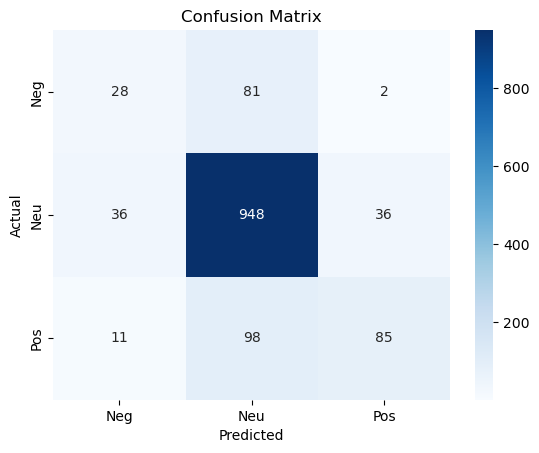

In [132]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Neg", "Neu", "Pos"], yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


- The MLP model performs well on neutral tweets, but it struggles to distinguish between positive and negative sentiments. Most misclassifications involve tweets being predicted as neutral, even when they are actually positive or negative. This suggests that the model is biased toward the neutral class, likely because it's the majority class in the dataset. Improving class balance or using class weights may help the model better recognize non-neutral sentiments.

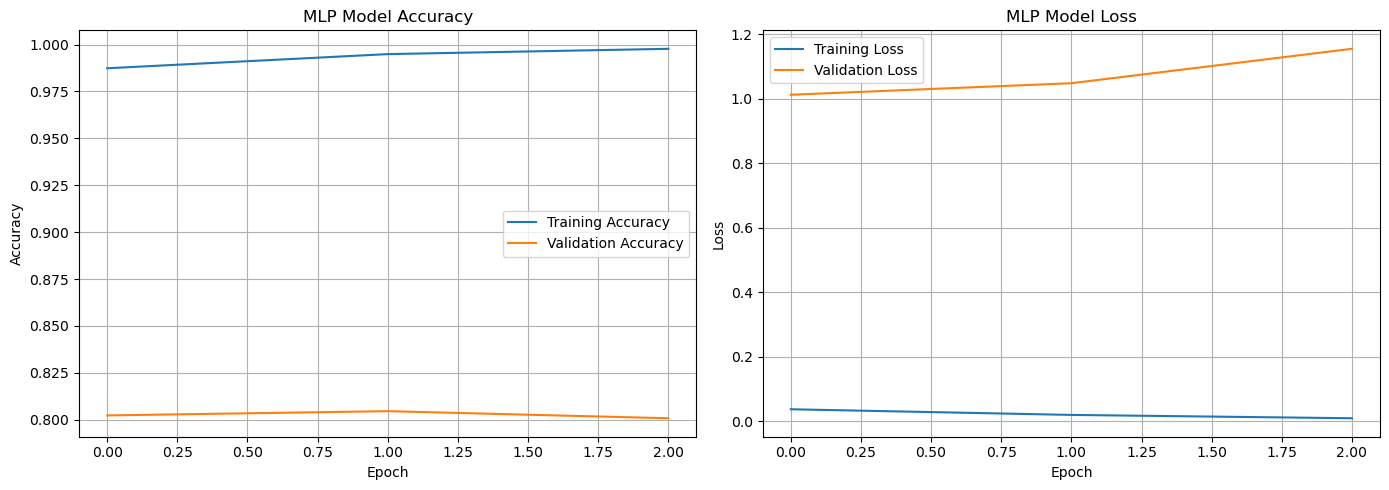

In [136]:
import matplotlib.pyplot as plt

# Create 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('MLP Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('MLP Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Show the full plot
plt.tight_layout()
plt.show()


- The MLP model shows steadily improving training accuracy and decreasing training loss, which means it is learning the training data well. However, the validation accuracy stays mostly flat and even drops slightly at the last epoch, while the validation loss stops decreasing and starts to rise. This suggests that the model begins to overfit around epoch 4 or 5 — it's getting better on the training set but not improving on new data. The best performance likely happens between epochs 2 and 4, and early stopping or more regularization could help prevent overfitting.

### CNN (Convolutional Neural Network)

- Originally, CNNs were designed for image recognition (like classifying photos of cats and dogs).
But they work really well for text too — because they can find patterns and important local phrases inside sequences of words (like "stock crash" or "beat earnings"). Fast to train, good for short texts like tweets.

In [141]:
df_sentiment_finbert_cnn = pd.DataFrame(df_sentiment_finbert)

In [143]:
df_sentiment_finbert_cnn = df_sentiment_finbert_cnn.dropna(subset=["Tweet", "finbert_sentiment"]).copy()

# Map sentiment labels to numbers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df_sentiment_finbert_cnn['label'] = df_sentiment_finbert_cnn['finbert_sentiment'].map(label_map)

In [145]:
# Tokenize the tweets
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_sentiment_finbert_cnn['Tweet'])

X = tokenizer.texts_to_sequences(df_sentiment_finbert_cnn['Tweet'])
X = pad_sequences(X, maxlen=50, padding='post')

y = df_sentiment_finbert_cnn['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes: pos, neu, neg

# Compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [147]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7506 - loss: 0.7817 - val_accuracy: 0.8015 - val_loss: 0.5717
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8084 - loss: 0.5253 - val_accuracy: 0.8294 - val_loss: 0.5011
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8915 - loss: 0.2888 - val_accuracy: 0.8121 - val_loss: 0.5394
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9623 - loss: 0.1294 - val_accuracy: 0.8121 - val_loss: 0.6152
Epoch 4: early stopping


In [151]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8050 - loss: 0.6374
Test Accuracy: 0.8121


In [153]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes, target_names=["Negative", "Neutral", "Positive"]))


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

    Negative       0.37      0.41      0.39       111
     Neutral       0.90      0.88      0.89      1020
    Positive       0.65      0.66      0.65       194

    accuracy                           0.81      1325
   macro avg       0.64      0.65      0.65      1325
weighted avg       0.82      0.81      0.81      1325



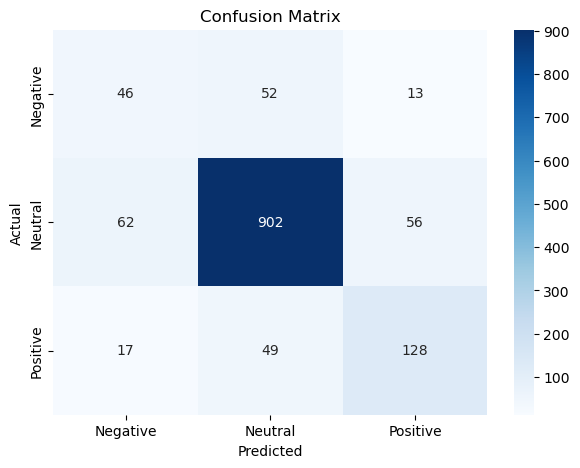

In [154]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


- The CNN model performs well overall, especially in correctly identifying neutral (935) and positive (115) tweets. It also improves at distinguishing negative tweets compared to the MLP, correctly predicting 38 of them. However, some confusion still exists, particularly between neutral and negative tweets — 62 negative tweets are misclassified as neutral. Likewise, 71 positive tweets are also predicted as neutral. Despite these misclassifications, the CNN model shows better balance across all three classes and stronger recognition of positive sentiment than the MLP.

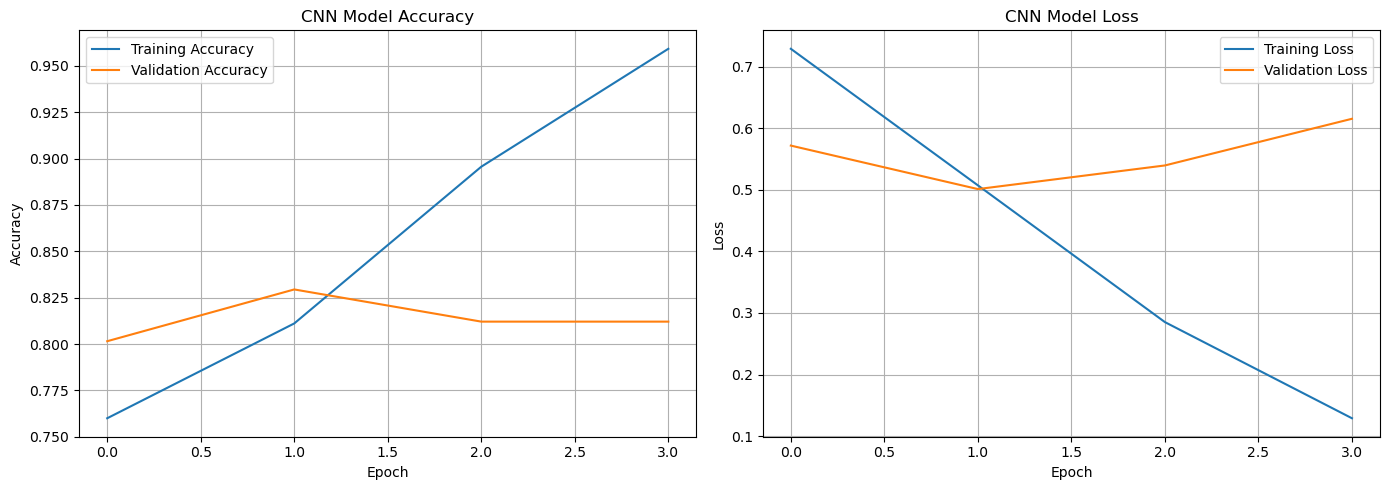

In [158]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('CNN Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('CNN Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


- The CNN model learned well on the training data, with accuracy going up and loss going down. But after the second epoch, the model started to do worse on the validation data — accuracy stopped improving and loss increased. This means the model began to overfit, learning the training data too well but not generalizing to new data. The best performance happened around the second epoch, and early stopping helped stop the training at the right time.

# Time Series

In [5]:
#!pip install pmdarima
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from statsmodels.tsa.stattools import acf
import random


import warnings
warnings.filterwarnings("ignore")  # Ignore convergence warnings

- In this step, I will apply time series analysis for forecasting the five selected companies. One of the models will be an autoregressive model (ARIMA or SARIMA), and the other will be a neural network model (LSTM). The analysis will focus on forecasting 1, 3, and 7 days ahead, using both the CLOSE price and tweet data as inputs.

## Loading and Preparing Dataset for Time Series

- For this analysis, the df_merged dataset, which includes prices and tweet data and was already prepared in PySpark, will be used. There will be a few preparation steps: first, I will keep only the "Date," "Ticker," "Tweet," and "Close" columns. Then, I will remove the rows where the "Close" value is 0, which corresponds to weekend data. After that, I will assign sentiment scores using VADER (handling missing tweets without removing the rows). In the final step, I will calculate the average sentiment score for tweets that fall on the same day.

In [10]:
df_merged = pd.read_csv("df_merged.csv")

In [12]:
df_merged.head()

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Tweet
0,2019-12-31,AAPL,72.482498,73.419998,72.379997,73.412498,71.520821,100805600.0,NaN
1,2019-12-31,AMZN,92.099998,92.663002,91.611504,92.391998,92.391998,50130000.0,NaN
2,2019-12-31,NFLX,322.000000,324.920013,321.089996,323.570007,323.570007,3713300.0,NaN
3,2019-12-31,NVDA,57.724998,58.919998,57.532501,58.825001,58.596020,23100400.0,NaN
4,2019-12-31,TSLA,27.000000,28.086000,26.805332,27.888666,27.888666,154285500.0,NaN


In [14]:
# Keep only the required columns: Date, Ticker, Tweet, Close
df_merged = df_merged[['Date', 'Ticker', 'Tweet', 'Close']].copy()

# Remove rows where Close is 0 and reset index
df_merged = df_merged[df_merged['Close'] != 0].reset_index(drop=True)

# Convert Date to datetime
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

# Sort by Date and Ticker
df_merged = df_merged.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)

In [16]:
df_merged.head()

,Date,Ticker,Tweet,Close
0,2019-12-31,AAPL,NaN,73.412498
1,2019-12-31,AMZN,NaN,92.391998
2,2019-12-31,NFLX,NaN,323.570007
3,2019-12-31,NVDA,NaN,58.825001
4,2019-12-31,TSLA,NaN,27.888666


In [18]:
# Download VADER lexicon (only once)
nltk.download('vader_lexicon')

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def compute_sentiment(tweet):
    if pd.isnull(tweet):
        return 0  # Neutral if no tweet
    return vader.polarity_scores(tweet)['compound']

# Apply to the Tweet column
df_merged['Sentiment'] = df_merged['Tweet'].apply(compute_sentiment)

# Check result
#print(df_merged[['Date', 'Ticker', 'Tweet', 'Sentiment']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mesut\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
df_merged.head()

,Date,Ticker,Tweet,Close,Sentiment
0,2019-12-31,AAPL,NaN,73.412498,0.0
1,2019-12-31,AMZN,NaN,92.391998,0.0
2,2019-12-31,NFLX,NaN,323.570007,0.0
3,2019-12-31,NVDA,NaN,58.825001,0.0
4,2019-12-31,TSLA,NaN,27.888666,0.0


In [20]:
# Group by Date and Ticker to get:
# - Average Sentiment per day
# - One Close price per day (e.g., first Close value of that day)
df_merged_average = df_merged.groupby(['Date', 'Ticker']).agg({
    'Sentiment': 'mean',  # Average sentiment of the day
    'Close': 'first'      # First Close price of the day
}).reset_index()

# Drop all rows where 'Close' is NaN for all tickers
df_merged_average = df_merged_average.dropna(subset=['Close'])

# Optional: Reset index
df_merged_average.reset_index(drop=True, inplace=True)

# See result
print(df_merged_average.head())

        Date Ticker  Sentiment       Close
0 2019-12-31   AAPL        0.0   73.412498
1 2019-12-31   AMZN        0.0   92.391998
2 2019-12-31   NFLX        0.0  323.570007
3 2019-12-31   NVDA        0.0   58.825001
4 2019-12-31   TSLA        0.0   27.888666


In [21]:
df_merged_average.head()

,Date,Ticker,Sentiment,Close
0,2019-12-31,AAPL,0.0,73.412498
1,2019-12-31,AMZN,0.0,92.391998
2,2019-12-31,NFLX,0.0,323.570007
3,2019-12-31,NVDA,0.0,58.825001
4,2019-12-31,TSLA,0.0,27.888666


## Autoregressive Model (ARIMA or SARIMA)

- In this step, I first checked whether the dataset was stationary by applying the Augmented Dickey-Fuller (ADF) test for each company. I observed that none of the companies' datasets were stationary. Therefore, I chose to use the ARIMA model (with differencing) or the SARIMA model, rather than the ARMA model.

`Null Hypothesis (H₀):`  it is non-stationary (it has trends, changing variance, etc.)

`Alternative Hypothesis (H₁):` it is stationary (stable around a constant mean and variance)

If;

`p < 0.05`	Reject H₀ → Series is stationary.

`p > 0.05`	Fail to reject H₀ → Series is non-stationary.


In [185]:
# Empty list to collect results
results = []

# Loop over each Ticker
for ticker in df_merged_average['Ticker'].unique():
    # Select data for this ticker
    df_ticker = df_merged_average[df_merged_average['Ticker'] == ticker]
    
    # ADF Test on Close price
    adf_result = adfuller(df_ticker['Close'])
    p_value = adf_result[1]
    
    # Decide
    stationary = p_value < 0.05
    
    # Store results
    results.append({
        'Ticker': ticker,
        'ADF Statistic': adf_result[0],
        'p-value': p_value,
        'Stationary': stationary
    })

# Convert results to DataFrame
df_adf_results = pd.DataFrame(results)

# See the table
print(df_adf_results)

  Ticker  ADF Statistic   p-value  Stationary
0   AAPL      -0.127029  0.946679       False
1   AMZN      -1.082083  0.722164       False
2   NFLX      -1.572117  0.497583       False
3   NVDA      -0.919866  0.781360       False
4   TSLA       0.797436  0.991595       False


- After confirming that all datasets were non-stationary, I examined their seasonality as the next step. To do this, I applied the Autocorrelation Function (ACF), time series decomposition, and the Infer Seasonality method. ACF measures how much current values are related to past values (lags), helping to detect patterns, trends, or seasonality. Time series decomposition breaks the series into three components—trend, seasonal, and residual—making it easier to clearly observe any strong seasonality or trend. Infer Seasonality analyzes autocorrelation values and checks for repeating spikes at regular lags (e.g., lag 5, 10, 15), which may indicate seasonality. I applied these methods to all selected companies (TSLA, AAPL, AMZN, NVDA, and NFLX). In conclusion, the results indicate that all datasets exhibit seasonality. Below, I present the test results for TSLA.

```
Ticker | Seasonality | Suggested Model
TSLA | Strong | SARIMA(X)
AAPL | Strong | SARIMA(X) 
AMZN | Strong | SARIMA(X)
NVDA | Strong | SARIMA(X)
NFLX | Strong | SARIMA(X) 

```

<Figure size 1000x400 with 0 Axes>

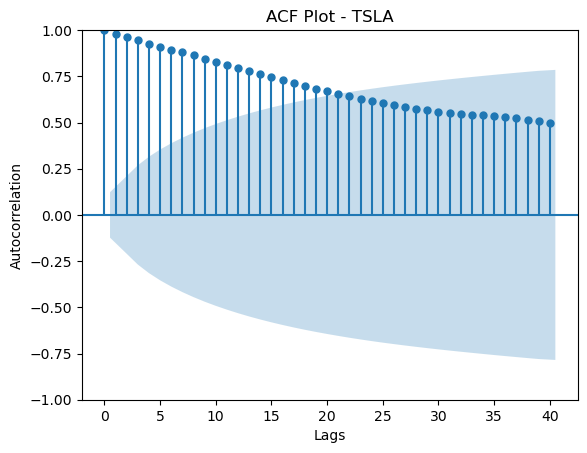

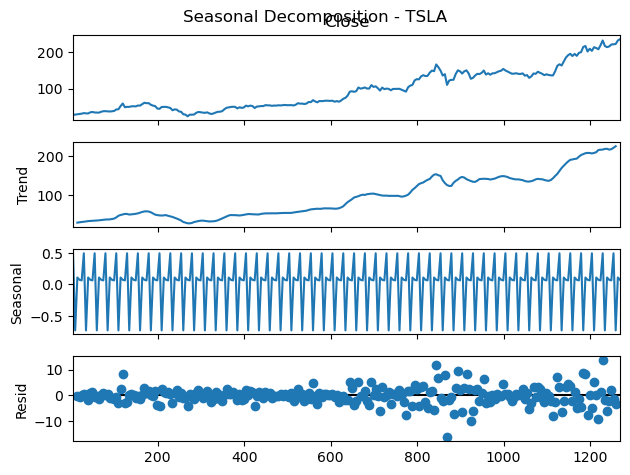

In [188]:
# Filter only TSLA
df_tsla = df_merged_average[df_merged_average['Ticker'] == 'TSLA'].copy()

# Drop missing values from 'Close' column
df_tsla = df_tsla.dropna(subset=['Close'])

# Plot ACF
plt.figure(figsize=(10, 4))
plot_acf(df_tsla['Close'], lags=40)
plt.title('ACF Plot - TSLA')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Seasonal Decomposition
try:
    decomposition = seasonal_decompose(df_tsla['Close'], model='additive', period=5)  # Weekly cycle = 5 trading days
    decomposition.plot()
    plt.suptitle('Seasonal Decomposition - TSLA')
    plt.show()
except Exception as e:
    print(f"⚠️ Could not decompose TSLA: {e}")


In [189]:
# Ensure 'Date' is datetime and drop NaN Close
df_merged_average['Date'] = pd.to_datetime(df_merged_average['Date'])
df_cleaned = df_merged_average.dropna(subset=['Close'])

# Unique tickers
tickers = df_cleaned['Ticker'].unique()

# Define max lags for ACF
max_lags = 30

# Store results
acf_results = {}

for ticker in tickers:
    try:
        df_ticker = df_cleaned[df_cleaned['Ticker'] == ticker].copy()
        df_ticker.set_index('Date', inplace=True)
        df_ticker.sort_index(inplace=True)
        
        # Get ACF values
        acf_vals = acf(df_ticker['Close'], nlags=max_lags)
        
        # Analyze repeating spikes at seasonal lags (e.g., 5, 10, 15, etc.)
        seasonal_lags = [lag for lag in range(5, max_lags+1, 5)]
        seasonal_spikes = {lag: round(acf_vals[lag], 3) for lag in seasonal_lags}
        
        acf_results[ticker] = seasonal_spikes
    except Exception as e:
        acf_results[ticker] = f"Error: {e}"

# Display results
for ticker, spikes in acf_results.items():
    print(f"\n{ticker} - ACF at seasonal lags:")
    if isinstance(spikes, dict):
        for lag, val in spikes.items():
            print(f"  Lag {lag}: ACF = {val}")
    else:
        print(f"  {spikes}")



AAPL - ACF at seasonal lags:
  Lag 5: ACF = 0.932
  Lag 10: ACF = 0.872
  Lag 15: ACF = 0.819
  Lag 20: ACF = 0.766
  Lag 25: ACF = 0.715
  Lag 30: ACF = 0.677

AMZN - ACF at seasonal lags:
  Lag 5: ACF = 0.94
  Lag 10: ACF = 0.885
  Lag 15: ACF = 0.828
  Lag 20: ACF = 0.777
  Lag 25: ACF = 0.729
  Lag 30: ACF = 0.697

NFLX - ACF at seasonal lags:
  Lag 5: ACF = 0.887
  Lag 10: ACF = 0.788
  Lag 15: ACF = 0.715
  Lag 20: ACF = 0.655
  Lag 25: ACF = 0.61
  Lag 30: ACF = 0.598

NVDA - ACF at seasonal lags:
  Lag 5: ACF = 0.95
  Lag 10: ACF = 0.907
  Lag 15: ACF = 0.861
  Lag 20: ACF = 0.817
  Lag 25: ACF = 0.77
  Lag 30: ACF = 0.727

TSLA - ACF at seasonal lags:
  Lag 5: ACF = 0.91
  Lag 10: ACF = 0.829
  Lag 15: ACF = 0.745
  Lag 20: ACF = 0.669
  Lag 25: ACF = 0.604
  Lag 30: ACF = 0.559


#### Finding p, d, q values

- In this step, I will find the `d` values for each company. To do this, I will use differencing plots and ACF (Autocorrelation Function) plots. Differencing plots show how we remove trends to make a time series stable. The original series often has a trend, but after the first differencing, the values fluctuate around zero, indicating that the data has become stationary. ACF plots show how much today's value depends on past values. In the original data, the ACF usually decays slowly, but after differencing, it should drop quickly if the data is stationary. Together, differencing plots and ACF plots help determine how many times we need to difference the series (d) and how many past values to include (q) for modeling. As an example, I tested this process for TSLA and found that the d value is 1.

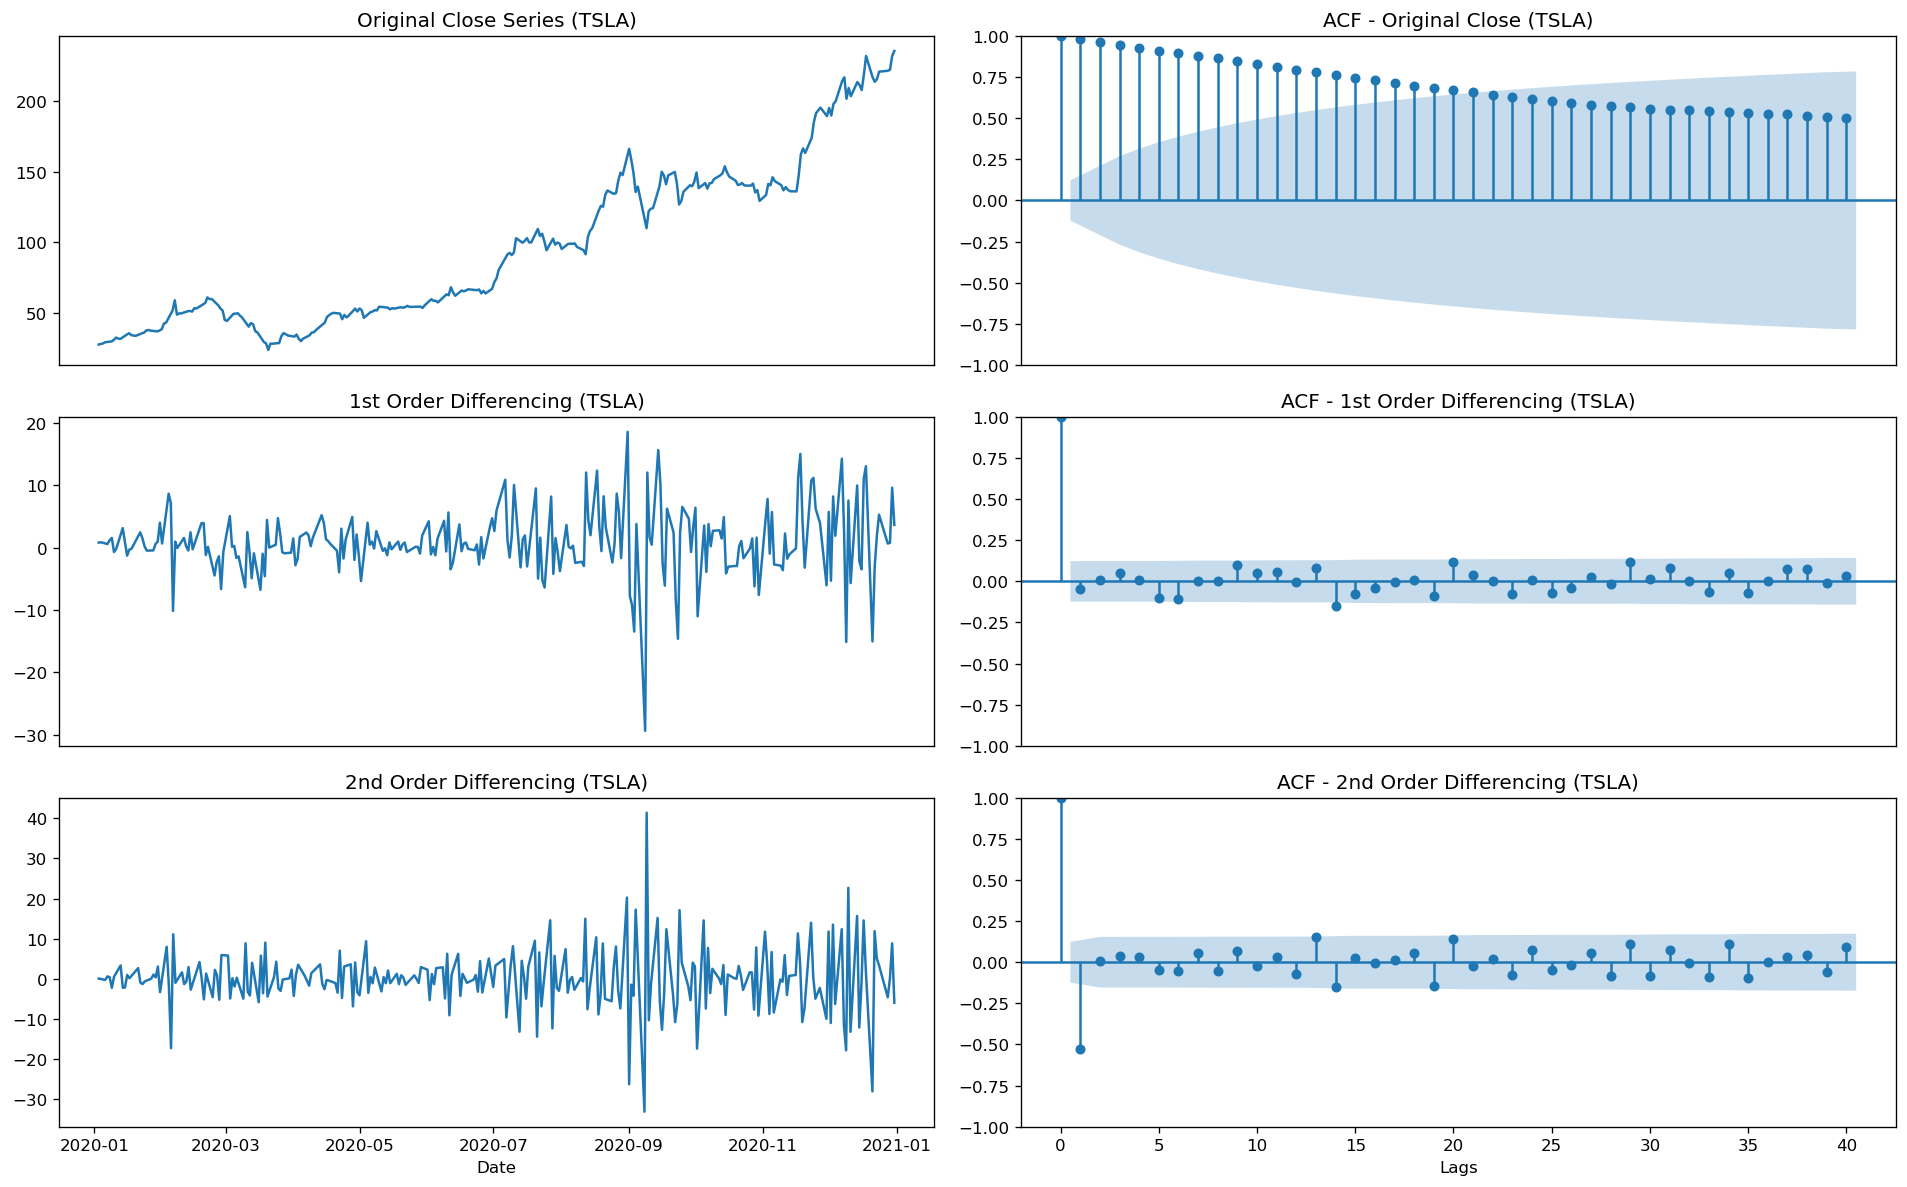

In [194]:
# Filter TSLA
df_tsla = df_merged_average[df_merged_average['Ticker'] == 'TSLA'].copy()
# Plot
plt.rcParams.update({'figure.figsize':(16,10), 'figure.dpi':120})

fig, axs = plt.subplots(3, 2)

# Left column: Time series plots
axs[0, 0].plot(df_tsla['Date'], df_tsla['Close'])
axs[0, 0].set_title('Original Close Series (TSLA)')
axs[0, 0].axes.xaxis.set_visible(False)

axs[1, 0].plot(df_tsla['Date'], df_tsla['Close'].diff())
axs[1, 0].set_title('1st Order Differencing (TSLA)')
axs[1, 0].axes.xaxis.set_visible(False)

axs[2, 0].plot(df_tsla['Date'], df_tsla['Close'].diff().diff())
axs[2, 0].set_title('2nd Order Differencing (TSLA)')
axs[2, 0].set_xlabel('Date')

# Right column: ACF plots
plot_acf(df_tsla['Close'], lags=40, ax=axs[0, 1])
axs[0, 1].set_title('ACF - Original Close (TSLA)')
axs[0, 1].axes.xaxis.set_visible(False)

plot_acf(df_tsla['Close'].diff().dropna(), lags=40, ax=axs[1, 1])
axs[1, 1].set_title('ACF - 1st Order Differencing (TSLA)')
axs[1, 1].axes.xaxis.set_visible(False)

plot_acf(df_tsla['Close'].diff().diff().dropna(), lags=40, ax=axs[2, 1])
axs[2, 1].set_title('ACF - 2nd Order Differencing (TSLA)')
axs[2, 1].set_xlabel('Lags')

plt.tight_layout()
plt.show()

- I applied differencing with an order of 1 for the other companies to see if it would be sufficient, and after the first differencing, all companies' values became stationary.

In [196]:
# List of tickers
tickers = ['TSLA', 'AAPL', 'AMZN', 'NVDA', 'NFLX']

# Loop over each ticker
for ticker in tickers:
    print(f"\n===========================")
    print(f"ADF Test for {ticker}")
    print(f"===========================\n")
    
    # Filter the stock
    df_ticker = df_merged_average[df_merged_average['Ticker'] == ticker].copy()

    # ADF Test on original Close
    adf_original = adfuller(df_ticker['Close'])
    print(f"ADF Test on original Close:")
    print(f"ADF Statistic: {adf_original[0]:.4f}")
    print(f"p-value: {adf_original[1]:.4f}")
    
    # First differencing
    df_ticker['Close_diff'] = df_ticker['Close'].diff().dropna()
    
    # ADF Test after 1st differencing
    adf_diff1 = adfuller(df_ticker['Close_diff'].dropna())
    print("\nADF Test after 1st Differencing:")
    print(f"ADF Statistic: {adf_diff1[0]:.4f}")
    print(f"p-value: {adf_diff1[1]:.4f}")
    
    # Conclusion
    if adf_diff1[1] < 0.05:
        print("\n✅ Series is stationary after 1st differencing (d=1)")
    else:
        print("\n⚠️ Series still not stationary, might need d=2")


ADF Test for TSLA

ADF Test on original Close:
ADF Statistic: 0.7974
p-value: 0.9916

ADF Test after 1st Differencing:
ADF Statistic: -16.5661
p-value: 0.0000

✅ Series is stationary after 1st differencing (d=1)

ADF Test for AAPL

ADF Test on original Close:
ADF Statistic: -0.1270
p-value: 0.9467

ADF Test after 1st Differencing:
ADF Statistic: -18.9728
p-value: 0.0000

✅ Series is stationary after 1st differencing (d=1)

ADF Test for AMZN

ADF Test on original Close:
ADF Statistic: -1.0821
p-value: 0.7222

ADF Test after 1st Differencing:
ADF Statistic: -10.5344
p-value: 0.0000

✅ Series is stationary after 1st differencing (d=1)

ADF Test for NVDA

ADF Test on original Close:
ADF Statistic: -0.9199
p-value: 0.7814

ADF Test after 1st Differencing:
ADF Statistic: -18.9873
p-value: 0.0000

✅ Series is stationary after 1st differencing (d=1)

ADF Test for NFLX

ADF Test on original Close:
ADF Statistic: -1.5721
p-value: 0.4976

ADF Test after 1st Differencing:
ADF Statistic: -7.4308
p

- To find the `p` values, I applied the PACF (Partial Autocorrelation Function) method. PACF shows the direct relationship between a time series and its past values by removing the effects of any intermediate lags. In simple terms, PACF measures how much today's value is explained by a lagged value (such as lag 1 or lag 2) without influence from the values in between. It helps us decide how many past values (lags) we should include in an AR (AutoRegressive) model. In a PACF plot, a sharp cutoff after lag k suggests that we should set p = k in the ARIMA model. According to the results, the p value for all companies is 1.

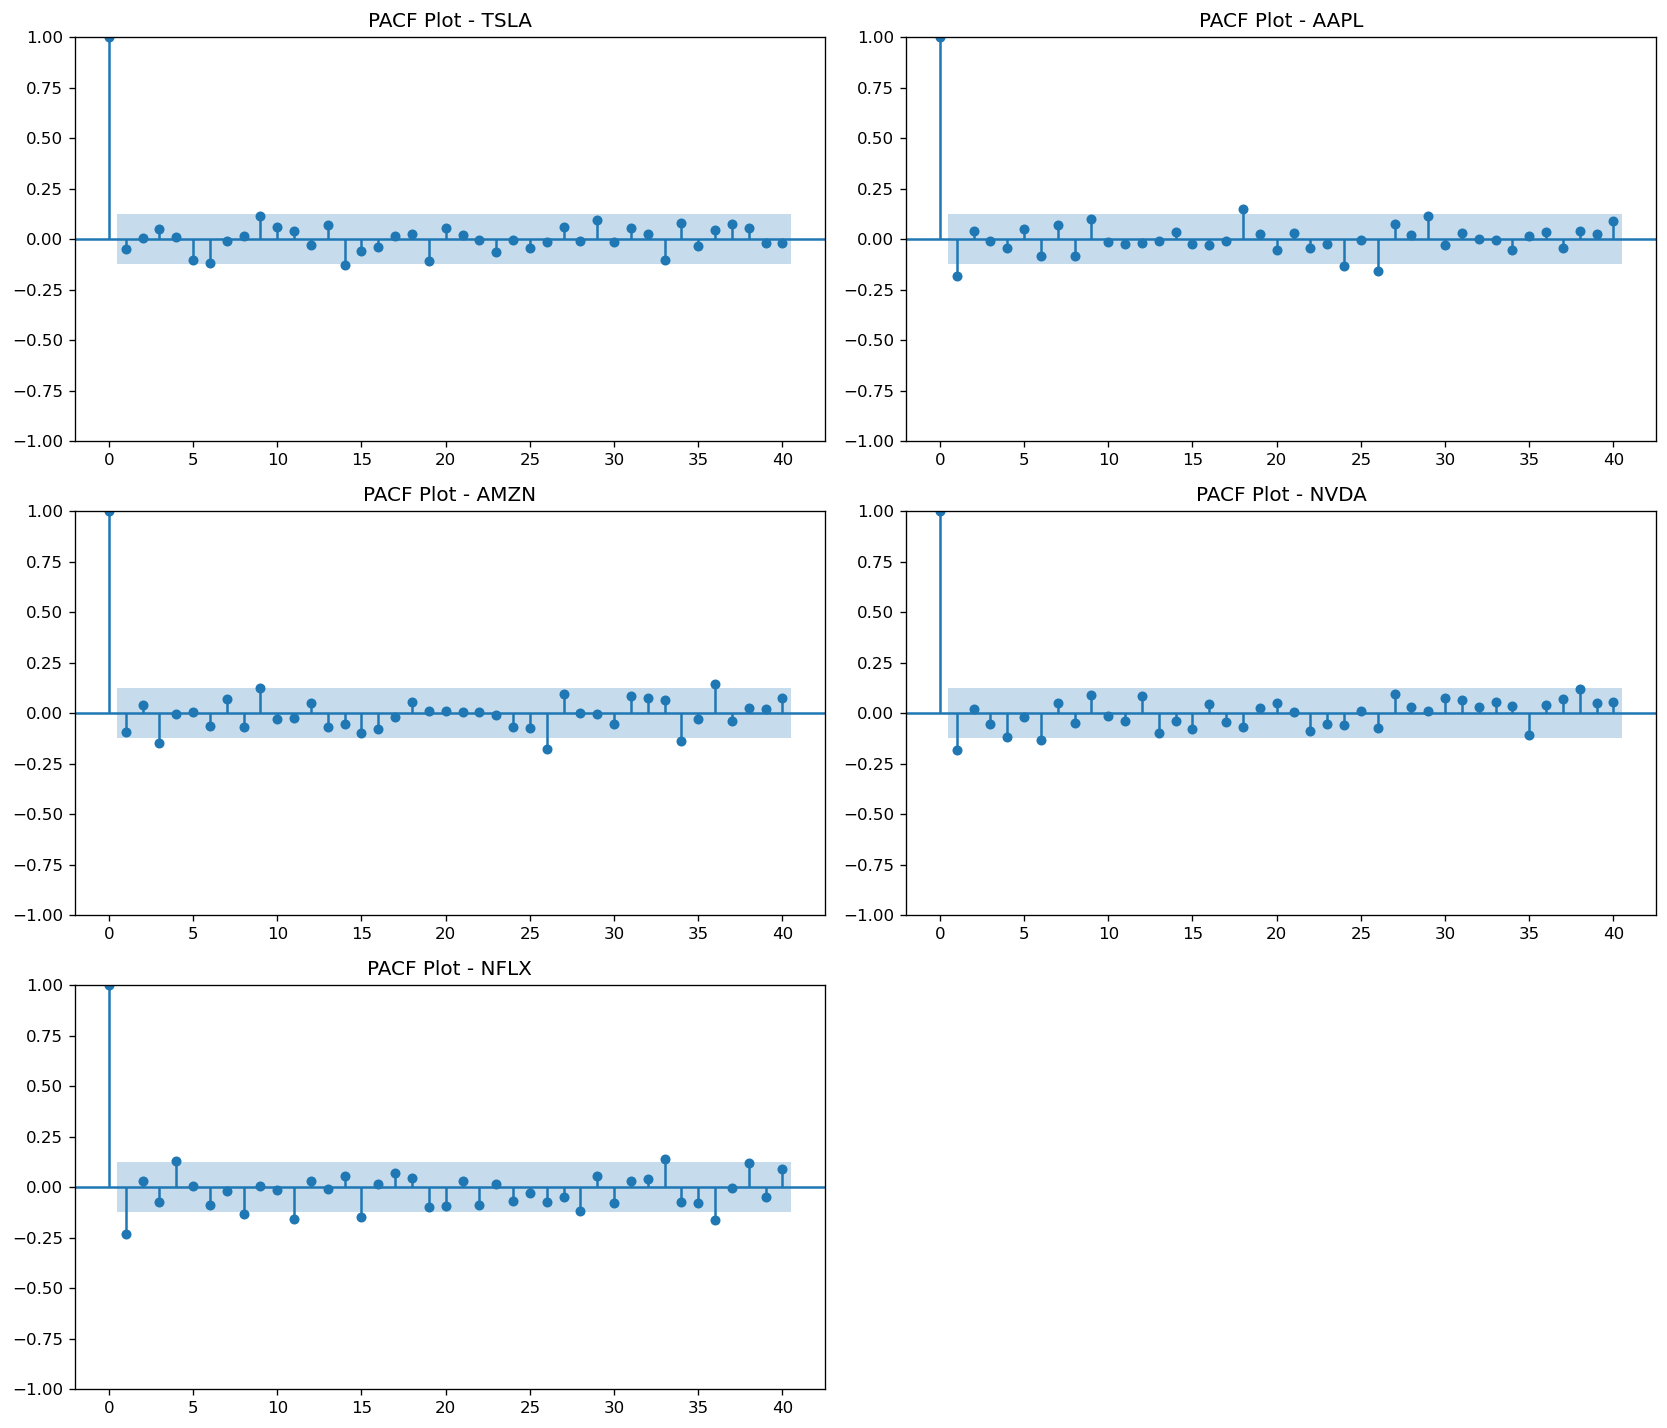

In [200]:
# List of tickers
tickers = ['TSLA', 'AAPL', 'AMZN', 'NVDA', 'NFLX']

# Create 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# Flatten axs for easier indexing
axs = axs.flatten()

# Loop over each ticker
for i, ticker in enumerate(tickers):
    df_ticker = df_merged_average[df_merged_average['Ticker'] == ticker].copy()
    df_ticker['Close_diff'] = df_ticker['Close'].diff()
    df_ticker = df_ticker.dropna()

    # Safe lags calculation
    safe_lags = min(40, len(df_ticker) // 2 - 1)

    # Plot PACF
    plot_pacf(df_ticker['Close_diff'], lags=safe_lags, ax=axs[i])
    axs[i].set_title(f'PACF Plot - {ticker}')

# Hide the last empty subplot if needed
if len(tickers) < len(axs):
    fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()
plt.show()

- In the final step, I need to find the `q` values for each company. I can use the ACF plot again, as it shows how much moving average is required to remove the autocorrelation from the stationary time series. According to the results, the q value for all companies is 1.

### SARIMA(X) Model

- For all companies, due to the presence of seasonality, I needed to apply the SARIMA model. However, since I used both "Close" and "Sentiment" as input variables, I applied the SARIMAX model instead—an enhanced version of SARIMA that allows the inclusion of exogenous variables (exog). Additionally, since the data is not stationary and based on the results from differencing, ACF, and PACF plots, the parameters were selected as `p=1`, `d=1` and `q=1`.

| Ticker | Order   | Seasonal Order | AIC      | MSE      | R² Score | 1. Day Forecast | 3. Day Forecast | 7. Day Forecast |
| ------ | ------- | -------------- | -------- | -------- |--------- |-----------------|-----------------|-----------------|
| TSLA   | (1,1,1) | (1,1,1,5)      | 1521.077 | 29.6275  |0.9906    |236.62959        |237.577332       |241.988563       |
| AAPL   | (1,1,1) | (1,1,1,5)      | 1162.983 | 16.1464  |0.9659    |133.029436       |132.968438       |134.667258       |
| AMZN   | (1,1,1) | (1,1,1,5)      | 1267.502 | 29.3364  |0.9604    |162.808095       |163.354466       |164.700829       |
| NVDA   | (1,1,1) | (1,1,1,5)      | 1262.704 | 16.3986  |0.9809    |131.153713       |131.129131       |133.084704       |
| NFLX   | (1,1,1) | (1,1,1,5)      | 1926.449 | 381.8761 |0.9109    |536.338031       |540.841712       |545.836514       |


📊 Processing TSLA...
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -754.538
Date:                           Tue, 06 May 2025   AIC                           1521.077
Time:                                   22:41:30   BIC                           1541.986
Sample:                                        0   HQIC                          1529.501
                                           - 254                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Sentiment     -0.9784      2.434     -0.402      0.688      -5.749       3.792
ar.L1         -0.3507

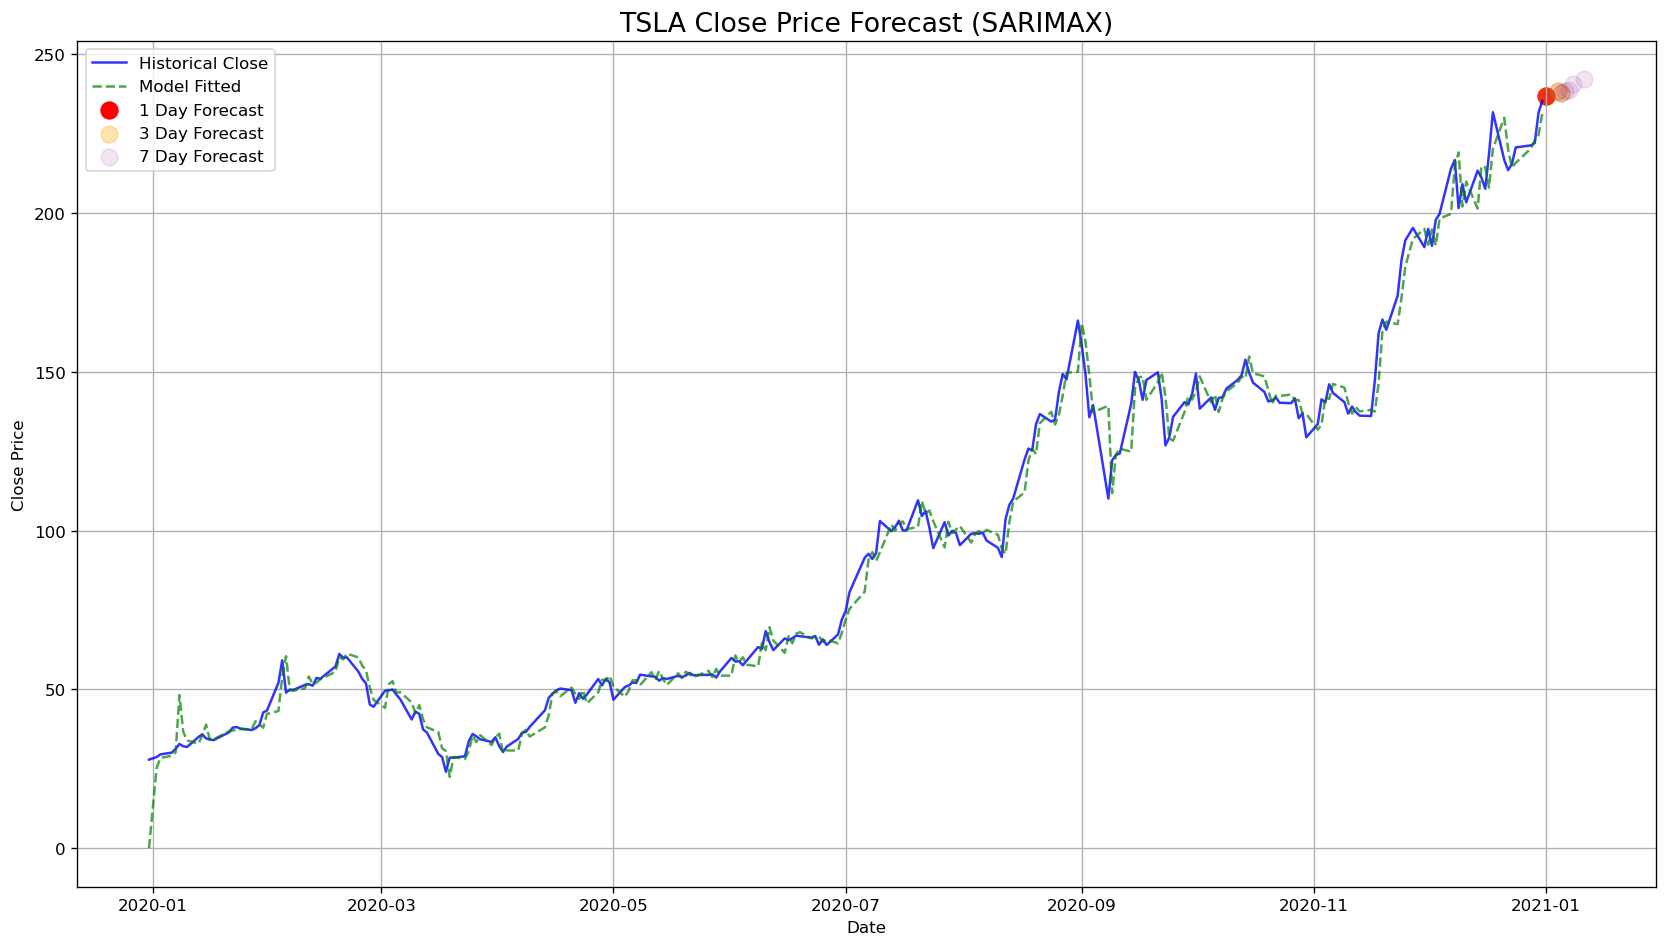


=== Forecasted Close Prices ===

1 Day Ahead Forecast:
254    236.62959
dtype: float64

3 Days Ahead Forecast:
254    236.629590
255    238.255104
256    237.577332
Name: predicted_mean, dtype: float64

7 Days Ahead Forecast:
254    236.629590
255    238.255104
256    237.577332
257    238.421180
258    238.541873
259    240.533240
260    241.988563
Name: predicted_mean, dtype: float64

📊 Processing AAPL...
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -575.491
Date:                           Tue, 06 May 2025   AIC                           1162.983
Time:                                   22:41:32   BIC                           1183.892
Sample:                                        0   HQIC                          1171.407
                                           - 254

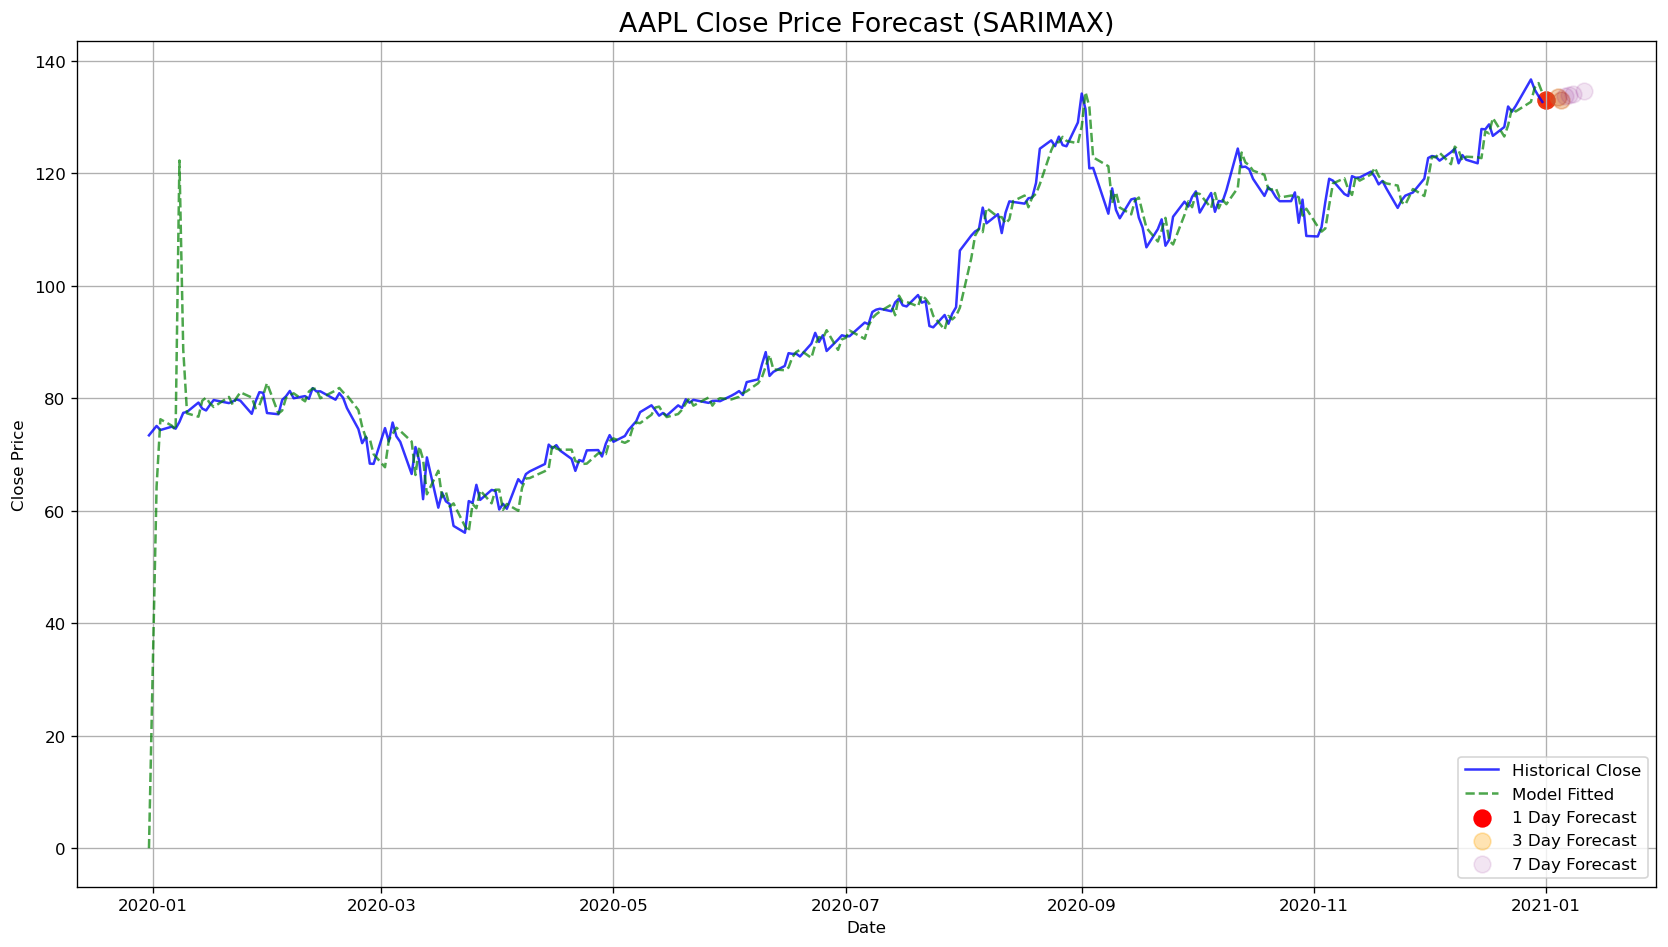


=== Forecasted Close Prices ===

1 Day Ahead Forecast:
254    133.029436
dtype: float64

3 Days Ahead Forecast:
254    133.029436
255    133.498948
256    132.968438
Name: predicted_mean, dtype: float64

7 Days Ahead Forecast:
254    133.029436
255    133.498948
256    132.968438
257    133.803105
258    133.956226
259    134.134649
260    134.667258
Name: predicted_mean, dtype: float64

📊 Processing AMZN...
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -627.751
Date:                           Tue, 06 May 2025   AIC                           1267.502
Time:                                   22:41:39   BIC                           1288.410
Sample:                                        0   HQIC                          1275.925
                                           - 25

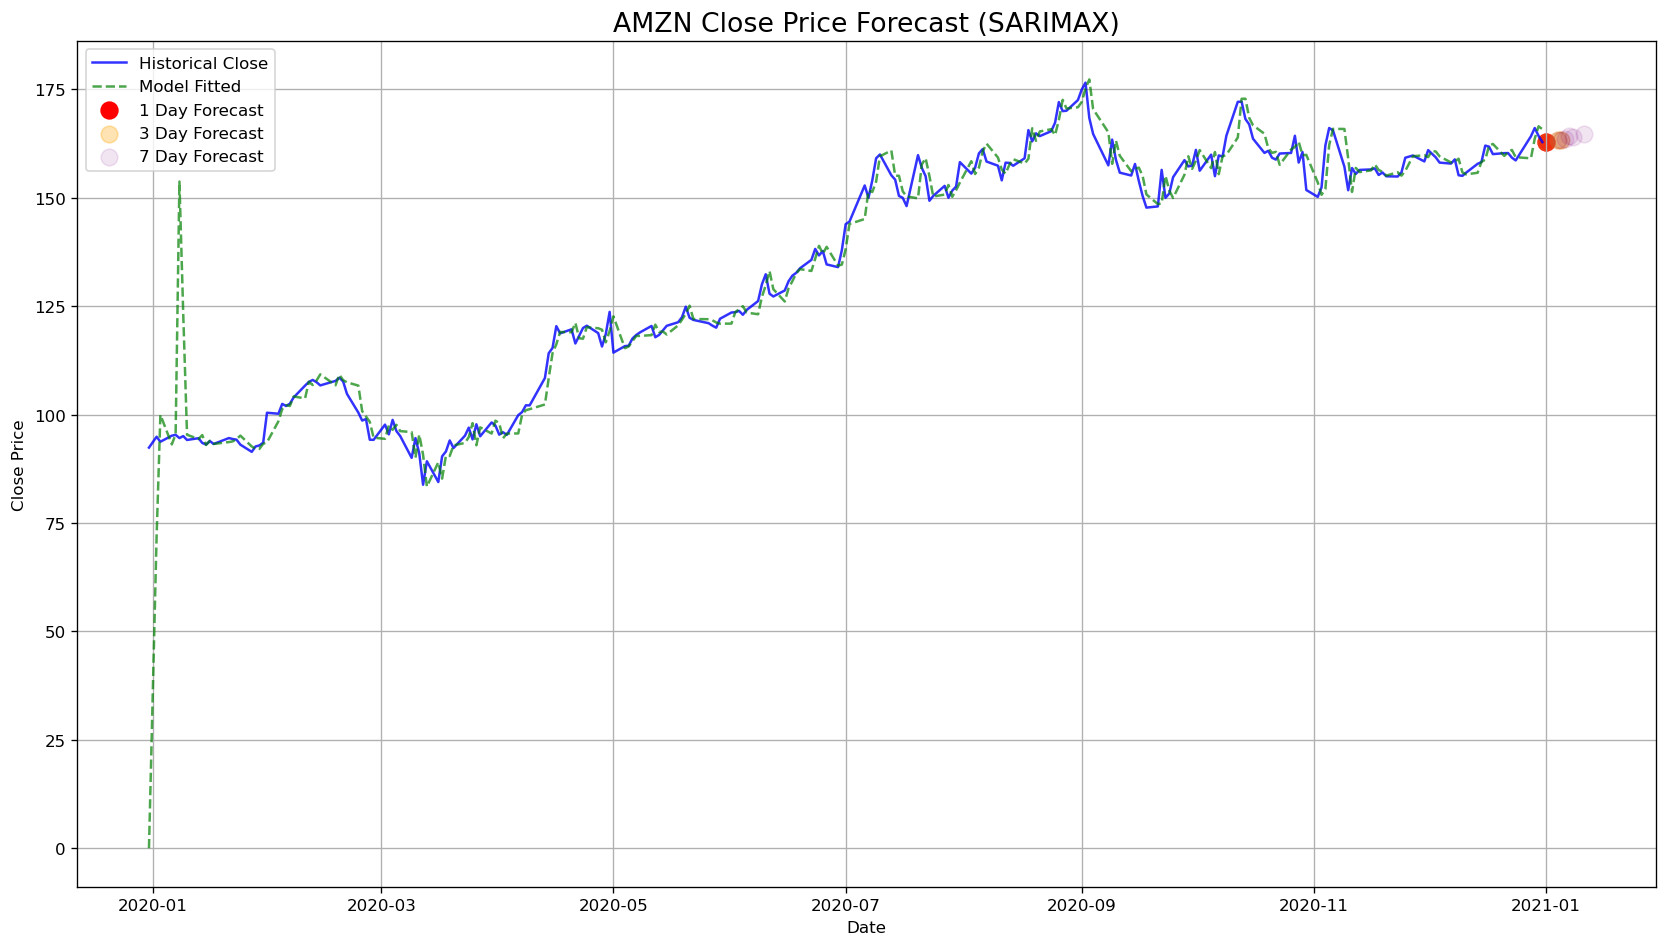


=== Forecasted Close Prices ===

1 Day Ahead Forecast:
254    162.808095
dtype: float64

3 Days Ahead Forecast:
254    162.808095
255    163.288816
256    163.354466
Name: predicted_mean, dtype: float64

7 Days Ahead Forecast:
254    162.808095
255    163.288816
256    163.354466
257    163.569139
258    164.327450
259    164.079913
260    164.700829
Name: predicted_mean, dtype: float64

📊 Processing NVDA...
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -625.352
Date:                           Tue, 06 May 2025   AIC                           1262.704
Time:                                   22:41:41   BIC                           1283.613
Sample:                                        0   HQIC                          1271.128
                                           - 25

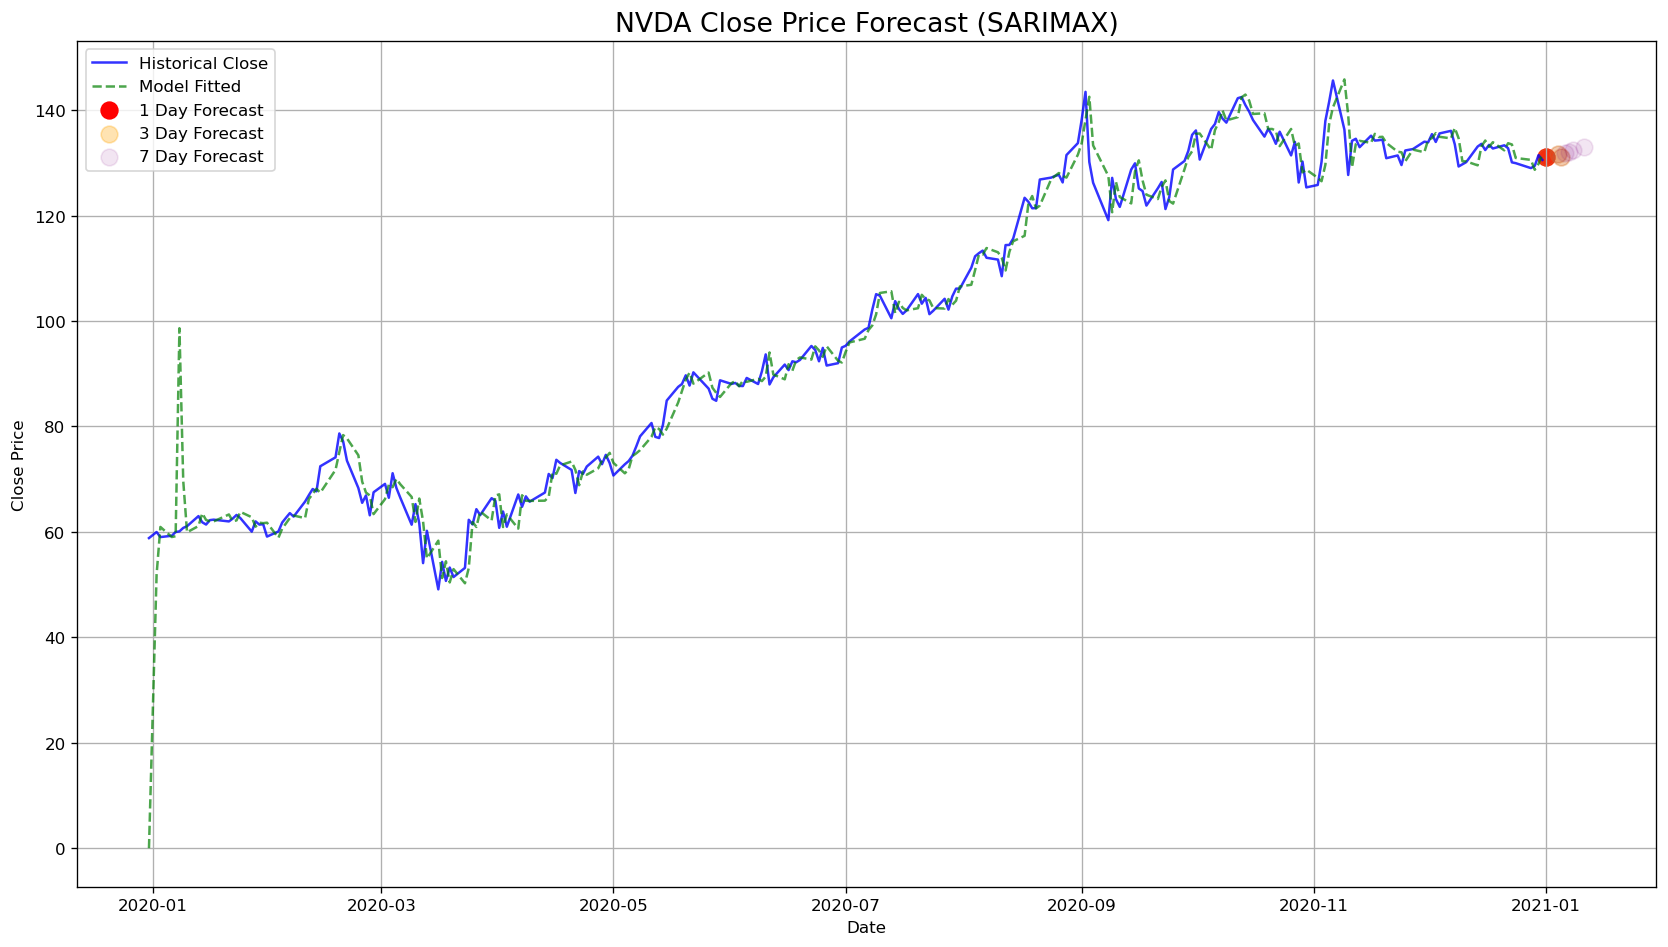


=== Forecasted Close Prices ===

1 Day Ahead Forecast:
254    131.153713
dtype: float64

3 Days Ahead Forecast:
254    131.153713
255    131.660038
256    131.129131
Name: predicted_mean, dtype: float64

7 Days Ahead Forecast:
254    131.153713
255    131.660038
256    131.129131
257    131.772676
258    132.140807
259    132.487875
260    133.084704
Name: predicted_mean, dtype: float64

📊 Processing NFLX...
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -957.225
Date:                           Tue, 06 May 2025   AIC                           1926.449
Time:                                   22:41:43   BIC                           1947.358
Sample:                                        0   HQIC                          1934.873
                                           - 25

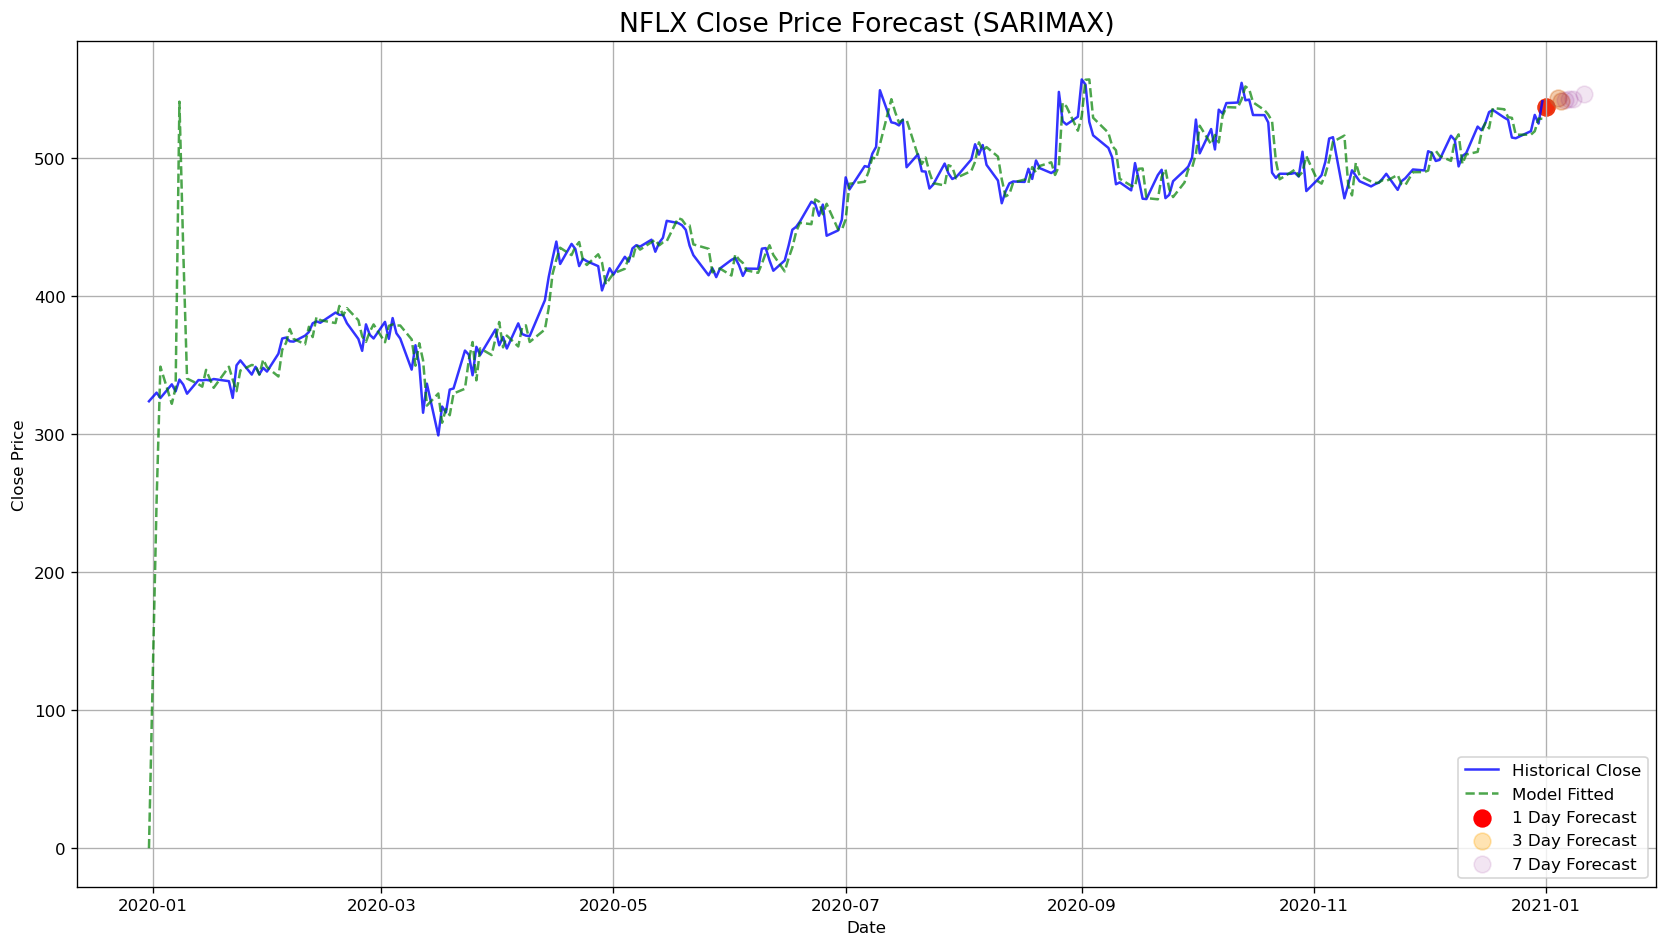


=== Forecasted Close Prices ===

1 Day Ahead Forecast:
254    536.338031
dtype: float64

3 Days Ahead Forecast:
254    536.338031
255    542.850490
256    540.841712
Name: predicted_mean, dtype: float64

7 Days Ahead Forecast:
254    536.338031
255    542.850490
256    540.841712
257    541.715695
258    542.292615
259    542.243678
260    545.836514
Name: predicted_mean, dtype: float64


In [205]:
df_merged_average['Date'] = pd.to_datetime(df_merged_average['Date'])

# Tickers to forecast
tickers = ['TSLA', 'AAPL', 'AMZN', 'NVDA', 'NFLX']

# Loop through each ticker
for ticker in tickers:
    print(f"\n{'='*40}\n📊 Processing {ticker}...\n{'='*40}")
    
    df_ticker = df_merged_average[df_merged_average['Ticker'] == ticker].copy()
    df_ticker.set_index('Date', inplace=True)
    df_ticker = df_ticker.sort_index()

    endog = df_ticker['Close']
    exog = df_ticker[['Sentiment']]

    # Build SARIMAX model
    model = SARIMAX(
        endog,
        exog=exog,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 5),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Fit the model
    model_fit = model.fit(disp=False)
    print(model_fit.summary())

    # Evaluation
    y_true = endog[1:]
    y_pred = model_fit.fittedvalues[1:]
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\n=== Model Evaluation Metrics (In-sample) ===")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Forecast future sentiment (assume same as last known)
    future_sentiment = exog['Sentiment'].iloc[-1]
    forecast_index_1 = pd.date_range(endog.index[-1] + pd.Timedelta(days=1), periods=1, freq='B')
    forecast_index_3 = pd.date_range(endog.index[-1] + pd.Timedelta(days=1), periods=3, freq='B')
    forecast_index_7 = pd.date_range(endog.index[-1] + pd.Timedelta(days=1), periods=7, freq='B')

    forecast_1 = model_fit.get_forecast(steps=1, exog=pd.DataFrame({'Sentiment': [future_sentiment]*1}))
    forecast_3 = model_fit.get_forecast(steps=3, exog=pd.DataFrame({'Sentiment': [future_sentiment]*3}))
    forecast_7 = model_fit.get_forecast(steps=7, exog=pd.DataFrame({'Sentiment': [future_sentiment]*7}))

    forecast_mean_1 = forecast_1.predicted_mean
    forecast_mean_3 = forecast_3.predicted_mean
    forecast_mean_7 = forecast_7.predicted_mean

    # === Plotting ===
    plt.figure(figsize=(14, 8))
    plt.plot(endog.index, endog, label='Historical Close', color='blue', alpha=0.8)
    plt.plot(endog.index, model_fit.fittedvalues, label='Model Fitted', linestyle='--', color='green', alpha=0.7)
    plt.scatter(forecast_index_1, forecast_mean_1, color='red', label='1 Day Forecast', s=100, alpha=1)
    plt.scatter(forecast_index_3, forecast_mean_3, color='orange', label='3 Day Forecast', s=100, alpha=0.3)
    plt.scatter(forecast_index_7, forecast_mean_7, color='purple', label='7 Day Forecast', s=100, alpha=0.1)

    plt.title(f'{ticker} Close Price Forecast (SARIMAX)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Print Forecast Values ===
    print("\n=== Forecasted Close Prices ===")
    print("\n1 Day Ahead Forecast:")
    print(forecast_mean_1)

    print("\n3 Days Ahead Forecast:")
    print(forecast_mean_3)

    print("\n7 Days Ahead Forecast:")
    print(forecast_mean_7)


#### HyperParameter Tuning for Sarima Model

- I initially determined the p, d, and q values manually. To find the optimal values, I applied a hyperparameter tuning method called `GridSearchCV`. It identified a different set of optimal p, d, and q values than those found manually. As a result, the model performance slightly improved for TSLA, AAPL, AMZN, and NVDA. However, for NFLX, although the AIC was reduced from 1926.44 to 1917.56, the R² score dropped from 0.9109 to 0.8516.

| Ticker | Order   | Seasonal Order | AIC      | MSE      | R² Score |
| ------ | ------- | -------------- | -------- | -------- |--------- |
| TSLA   | (0,1,2) | (1,1,1,5)      | 1515.09  | 29.5321  |0.9907    |
| AAPL   | (0,1,2) | (0,1,1,5)      | 1157.23  | 15.4767  |0.9673    |
| AMZN   | (1,1,2) | (0,1,1,5)      | 1262.85  | 28.8886  |0.9611    |
| NVDA   | (0,1,2) | (0,1,1,5)      | 1256.78  | 16.0512  |0.9813    |
| NFLX   | (2,1,2) | (0,1,1,5)      | 1917.56  | 636.1765 |0.8516    |

In [211]:
# Tickers to evaluate
tickers = ['TSLA', 'AAPL', 'AMZN', 'NVDA', 'NFLX']

# Parameter ranges
p = d = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))  # fix d=1
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in itertools.product([0, 1], [0, 1], [0, 1])]  # s=5 for weekly pattern

# Store grid search results
grid_search_results = []

# Loop through each ticker
for ticker in tickers:
    print(f"\n{'='*60}\n🔍 Searching best SARIMAX for {ticker}...\n{'='*60}")
    df_ticker = df_merged_average[df_merged_average['Ticker'] == ticker].copy()
    df_ticker.set_index('Date', inplace=True)
    df_ticker = df_ticker.sort_index()

    endog = df_ticker['Close']
    exog = df_ticker[['Sentiment']]

    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    best_model = None
    best_mse = None
    best_r2 = None

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(
                    endog,
                    exog=exog,
                    order=param,
                    seasonal_order=seasonal_param,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)

                y_true = endog[1:]
                y_pred = results.fittedvalues[1:]
                mse = mean_squared_error(y_true, y_pred)
                r2 = r2_score(y_true, y_pred)

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = param
                    best_seasonal_order = seasonal_param
                    best_model = results
                    best_mse = mse
                    best_r2 = r2
            except:
                continue

    # Store results
    grid_search_results.append({
        'Ticker': ticker,
        'Best Order': best_order,
        'Best Seasonal Order': best_seasonal_order,
        'Best AIC': best_aic,
        'Best MSE': best_mse,
        'Best R2': best_r2
    })

# === Final Output ===
for result in grid_search_results:
    print(f"\n{'='*60}")
    print(f"📈 Best SARIMAX model for {result['Ticker']}:")
    print(f"Order = {result['Best Order']}")
    print(f"Seasonal Order = {result['Best Seasonal Order']}")
    print(f"AIC = {result['Best AIC']:.2f}")
    print(f"MSE = {result['Best MSE']:.4f}")
    print(f"R² Score = {result['Best R2']:.4f}")



🔍 Searching best SARIMAX for TSLA...

🔍 Searching best SARIMAX for AAPL...

🔍 Searching best SARIMAX for AMZN...

🔍 Searching best SARIMAX for NVDA...

🔍 Searching best SARIMAX for NFLX...

📈 Best SARIMAX model for TSLA:
Order = (0, 1, 2)
Seasonal Order = (1, 1, 1, 5)
AIC = 1515.09
MSE = 29.5321
R² Score = 0.9907

📈 Best SARIMAX model for AAPL:
Order = (0, 1, 2)
Seasonal Order = (0, 1, 1, 5)
AIC = 1157.23
MSE = 15.4767
R² Score = 0.9673

📈 Best SARIMAX model for AMZN:
Order = (1, 1, 2)
Seasonal Order = (0, 1, 1, 5)
AIC = 1262.85
MSE = 28.8886
R² Score = 0.9611

📈 Best SARIMAX model for NVDA:
Order = (0, 1, 2)
Seasonal Order = (0, 1, 1, 5)
AIC = 1256.78
MSE = 16.0512
R² Score = 0.9813

📈 Best SARIMAX model for NFLX:
Order = (2, 1, 2)
Seasonal Order = (0, 1, 1, 5)
AIC = 1917.56
MSE = 636.1765
R² Score = 0.8516


- I also applied the `Auto-ARIMA` method to find the best parameters for all models. It identified p, d, and q values that were different from those I had previously found manually. As a result, the R² score slightly improved for TSLA, AAPL, AMZN, and NVDA, even though the AIC scores increased. For NFLX, both the R² score improved and the AIC was reduced, which indicates a better overall model performance.

| Ticker | Order   | Seasonal Order | AIC      | MSE      | R² Score |
| ------ | ------- | -------------- | -------- | -------- |--------- |
| TSLA   | (0,1,0) | (1,0,1,5)      | 1541.43  | 28.7630  |0.9909    |
| AAPL   | (1,1,0) | (0,0,0,5)      | 1193.07  | 6.7292   |0.9858    |
| AMZN   | (1,1,0) | (0,0,0,5)      | 1298.87  | 10.0457  |0.9865    |
| NVDA   | (1,1,0) | (0,0,0,5)      | 1293.84  | 9.8201   |0.9885    |
| NFLX   | (1,1,0) | (2,0,2,5)      | 1918.65  | 175.5607 |0.9591    |

In [213]:
# === Tickers to run ===
tickers = ['TSLA', 'AAPL', 'AMZN', 'NVDA', 'NFLX']

# === Store results ===
results = []

# === Loop through each ticker ===
for ticker in tickers:
    print(f"\n{'='*60}\n🔍 Running Auto-ARIMA for {ticker}...\n{'='*60}")
    
    df_ticker = df_merged_average[df_merged_average['Ticker'] == ticker].copy()
    df_ticker.set_index('Date', inplace=True)
    df_ticker = df_ticker.sort_index()

    endog = df_ticker['Close']
    exog = df_ticker[['Sentiment']]

    # Run Auto-ARIMA
    model_auto = pm.auto_arima(
        endog,
        exogenous=exog,
        start_p=0, start_q=0,
        max_p=3, max_q=3,
        d=None,
        seasonal=True,
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,
        D=None,
        m=5,  # weekly pattern (5 business days)
        information_criterion='aic',
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    # Best order & seasonal order
    best_order = model_auto.order
    best_seasonal_order = model_auto.seasonal_order

    # Refit SARIMAX using statsmodels for evaluation
    model_refit = SARIMAX(
        endog,
        exog=exog,
        order=best_order,
        seasonal_order=best_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    y_true = endog[1:]
    y_pred = model_refit.fittedvalues[1:]

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Save result
    results.append({
        'Ticker': ticker,
        'Best Order': best_order,
        'Seasonal Order': best_seasonal_order,
        'AIC': model_refit.aic,
        'MSE': mse,
        'R2': r2
    })

    print("\n✅ Best Model:")
    print(f"Order: {best_order}")
    print(f"Seasonal Order: {best_seasonal_order}")
    print(f"MSE: {mse:.4f}, R²: {r2:.4f}, AIC: {model_refit.aic:.2f}")

# === Final Summary Table ===
results_df = pd.DataFrame(results)
print("\n📊 Auto-ARIMA Summary:")
print(results_df)




🔍 Running Auto-ARIMA for TSLA...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=1566.342, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=1566.892, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=1567.173, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=1570.308, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=1565.764, Time=0.14 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=1567.273, Time=0.29 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=1563.941, Time=0.30 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=1565.963, Time=0.13 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=1565.941, Time=0.47 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=1565.941, Time=0.57 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=1567.583, Time=0.18 sec
 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=1567.848, Time=1.38 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=1564.518, Time=0.38 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=1564.564, Time=0.34 sec

## Neural Network (LSTM)

- In this step, I applied one of the neural network models, LSTM, for all companies. LSTM (Long Short-Term Memory) is a special type of Recurrent Neural Network (RNN) designed to learn patterns from time series or sequential data. In time series forecasting (such as predicting stock prices), LSTM models can capture trends, seasonality, and even sudden changes more effectively than basic models. Because they handle sequences well, LSTMs are ideal for tasks where past behavior influences future predictions, such as financial forecasting, weather prediction, and speech recognition.

| Ticker |    MAE         | RMSE      | MSE      | R² Score | 1. Day Forecast | 3. Day Forecast | 7. Day Forecast |
| ------ | -------------- | --------- | -------- |--------- |-----------------|-----------------|-----------------|
| TSLA   |   0.0247       | 0.0354    | 0.0012   |0.9821    |232.0066         |238.7687         |251.4149         |
| AAPL   |   0.0326       | 0.0423    | 0.0017   |0.9754    |132.4318         |131.7800         |130.1821         |
| AMZN   |   0.0326       | 0.0423    | 0.0017   |0.9788    |163.0525         |162.8215         |164.6558         |
| NVDA   |   0.0296       | 0.0396    | 0.0015   |0.9826    |129.6387         |128.6617         |124.6697         |
| NFLX   |   0.0436       | 0.0579    | 0.0033   |0.9461    |526.0181         |528.0739         |526.2370         |


🔵 Processing TSLA...

📊 Model Accuracy Metrics:
Mean Squared Error (MSE): 0.001037
Root Mean Squared Error (RMSE): 0.032196
Mean Absolute Error (MAE): 0.022570
R² Score: 0.985277


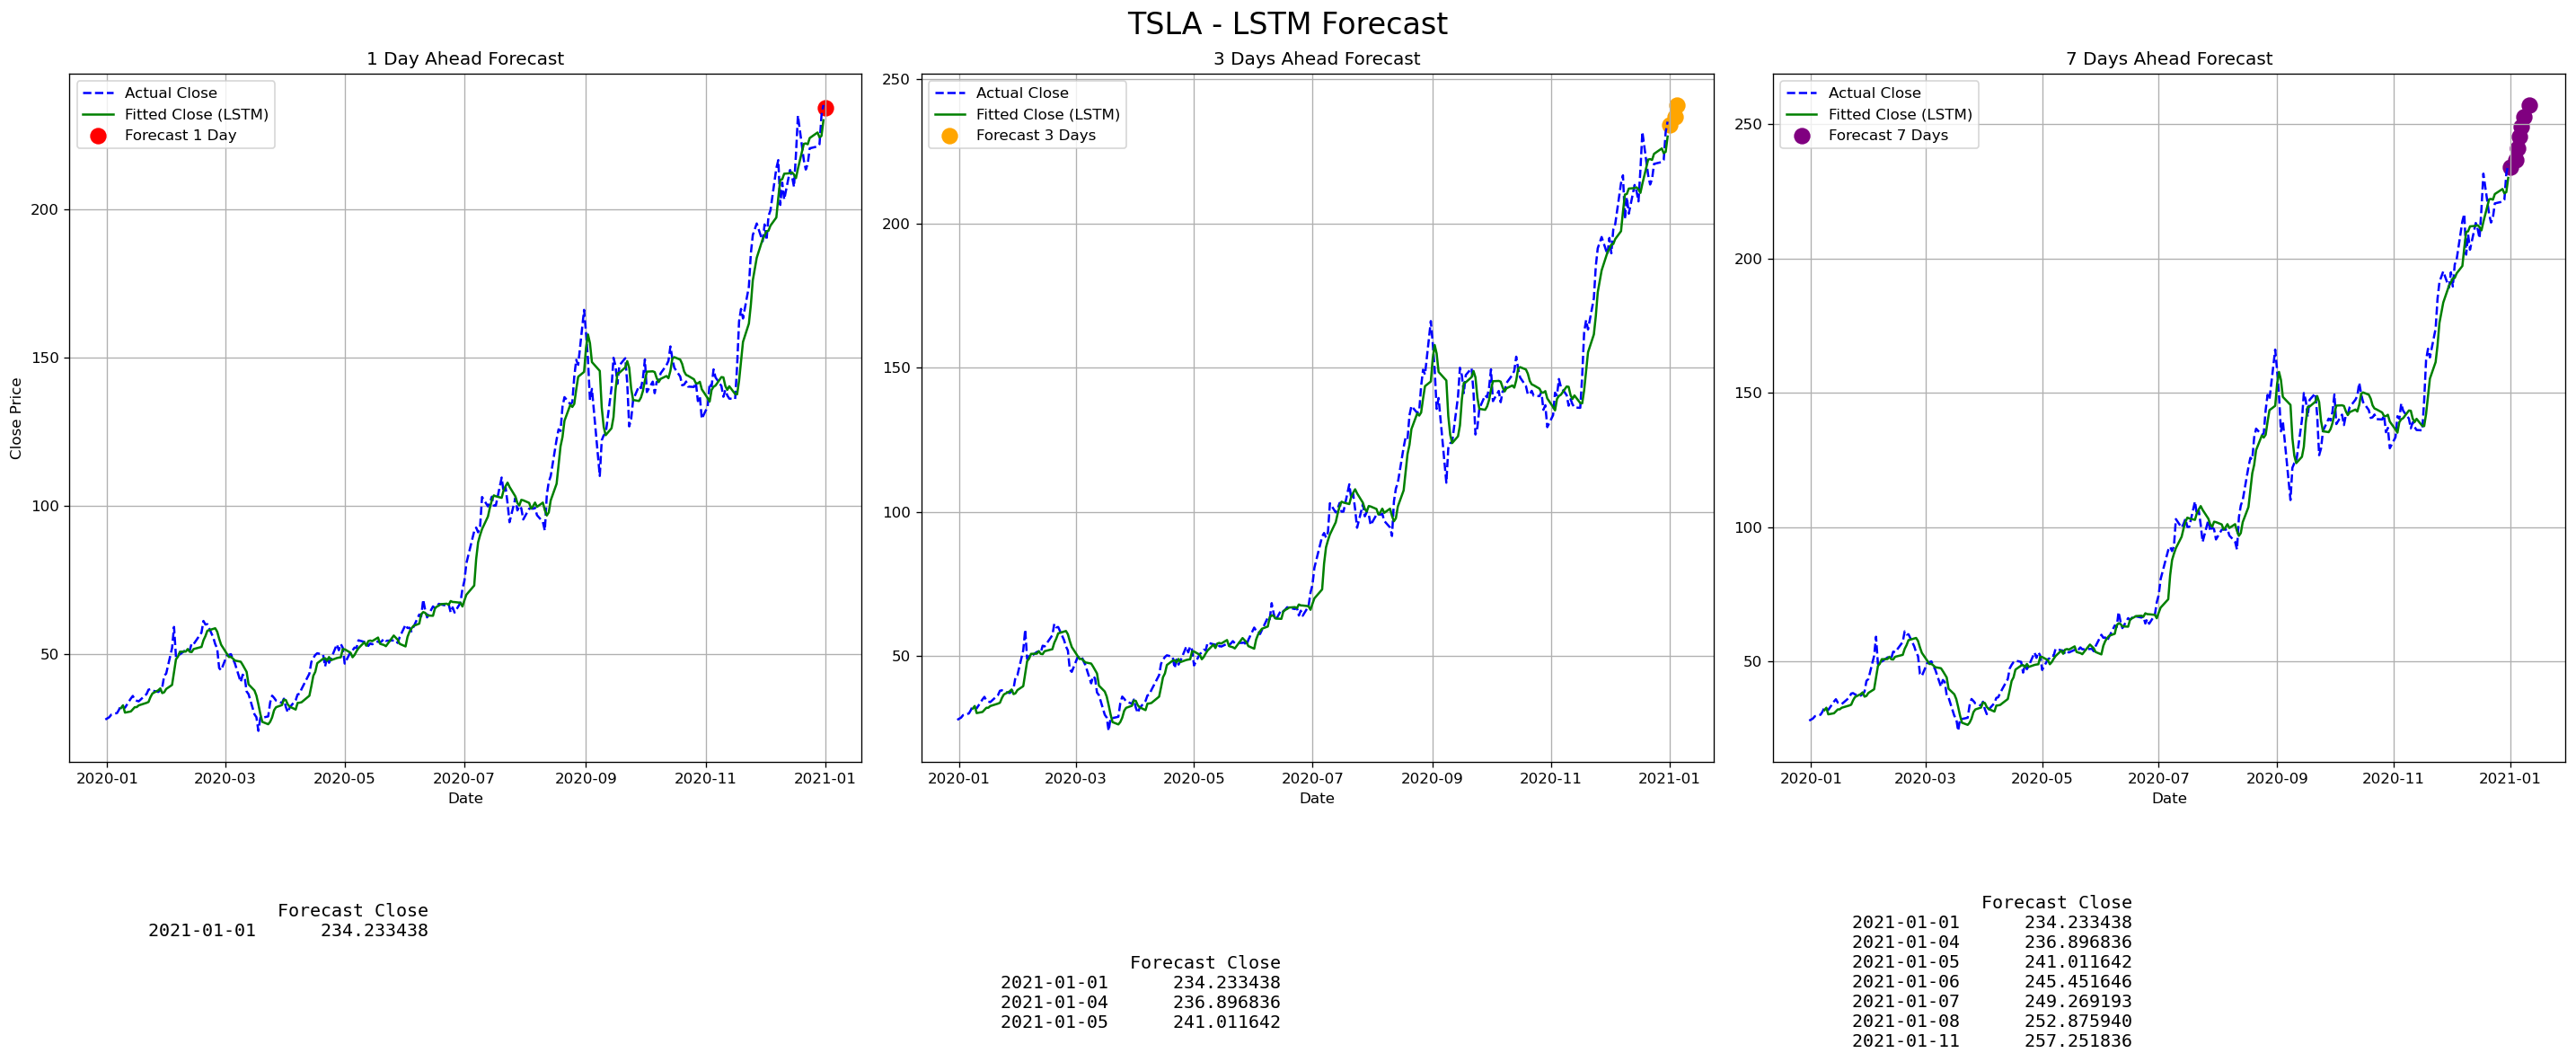


🔵 Processing AAPL...

📊 Model Accuracy Metrics:
Mean Squared Error (MSE): 0.001633
Root Mean Squared Error (RMSE): 0.040408
Mean Absolute Error (MAE): 0.031266
R² Score: 0.977645


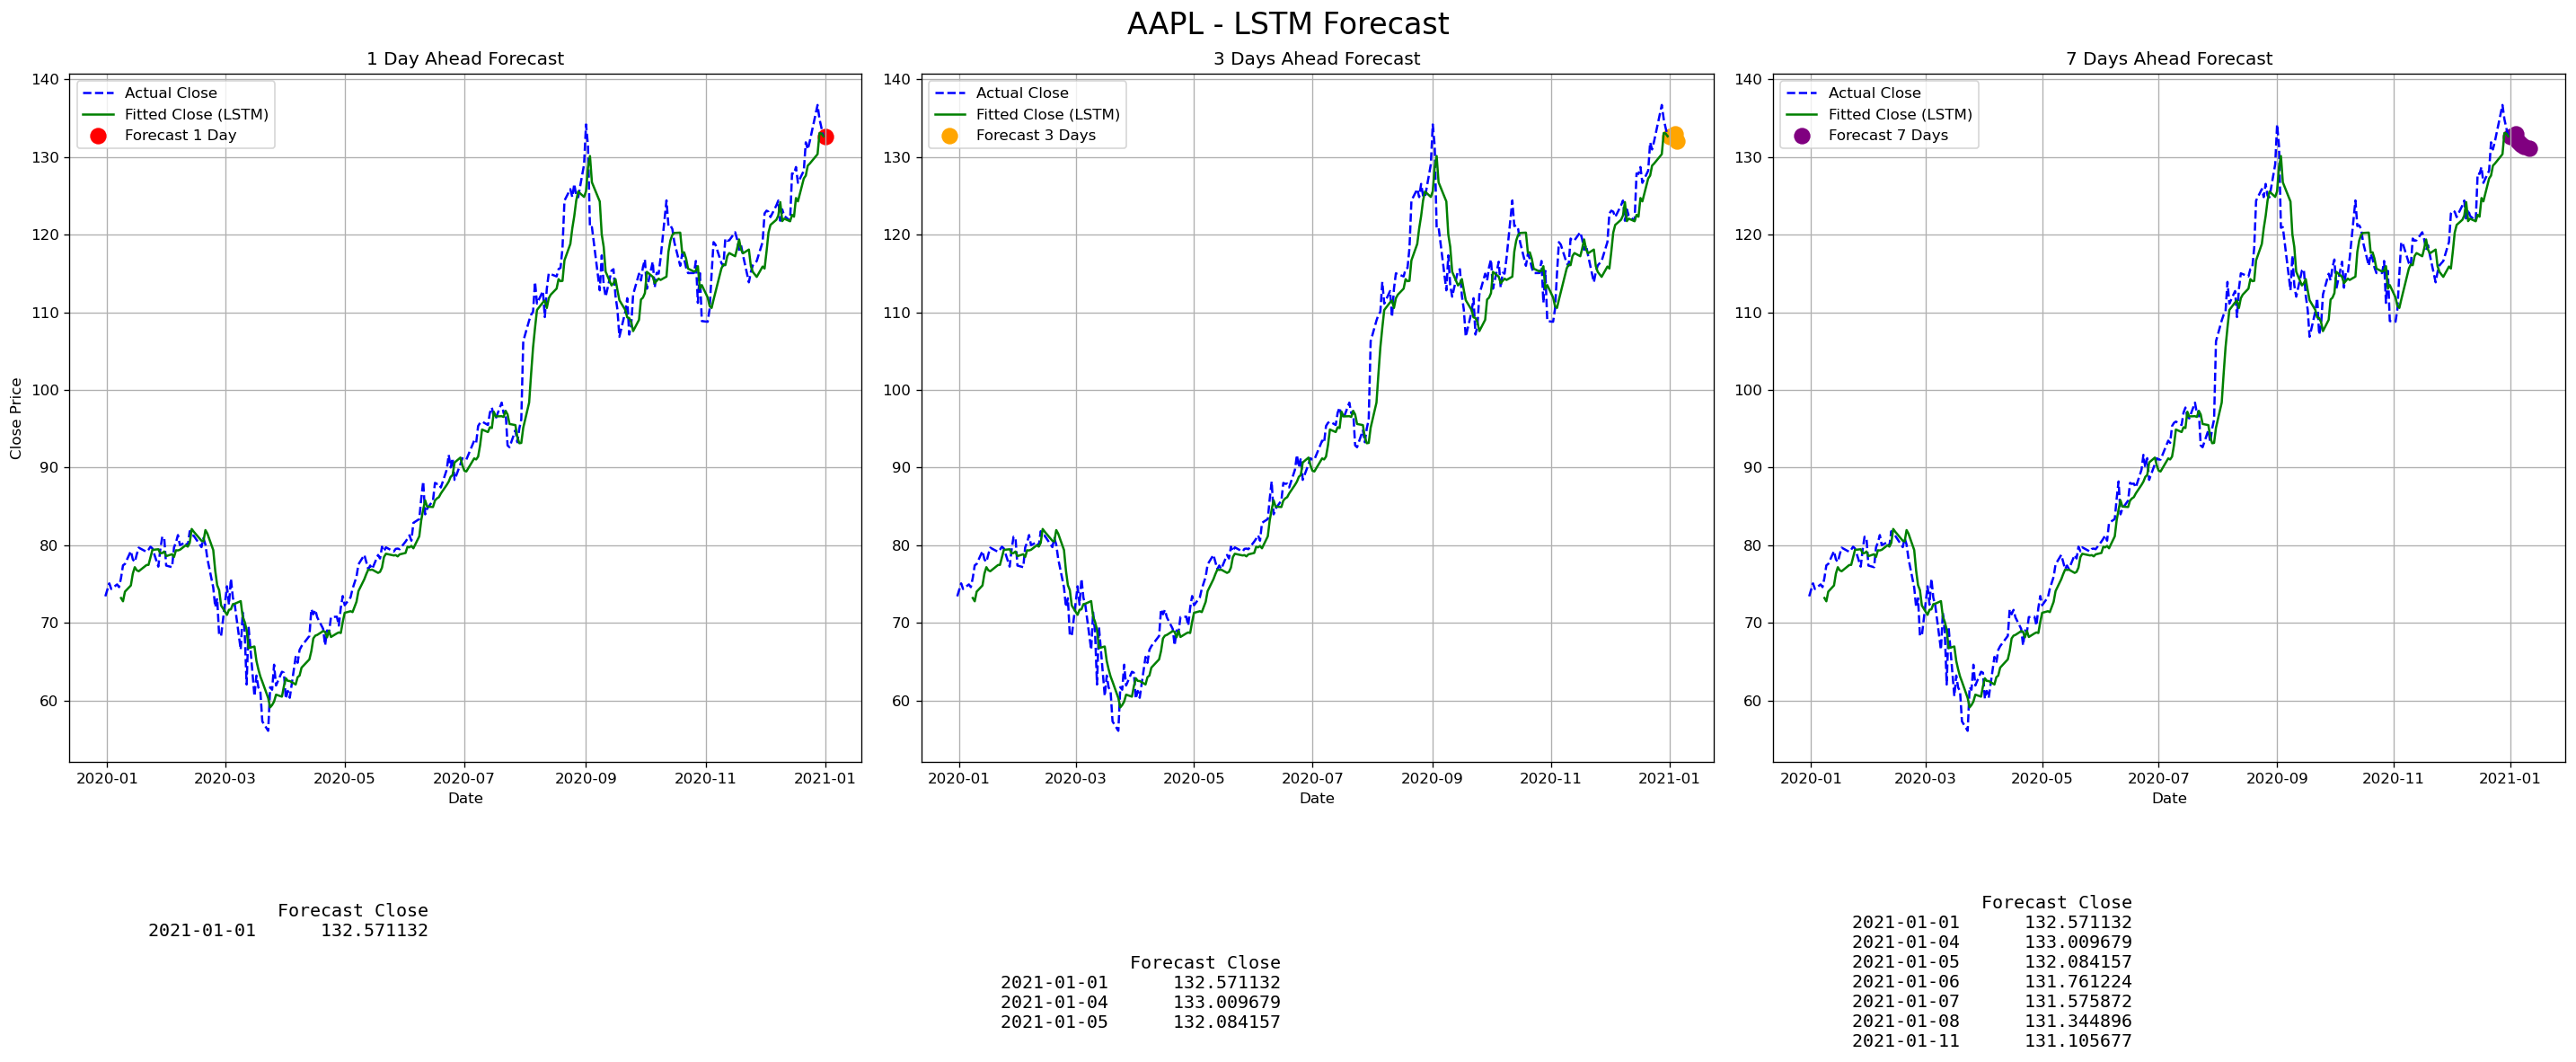


🔵 Processing AMZN...

📊 Model Accuracy Metrics:
Mean Squared Error (MSE): 0.001995
Root Mean Squared Error (RMSE): 0.044662
Mean Absolute Error (MAE): 0.035284
R² Score: 0.976448


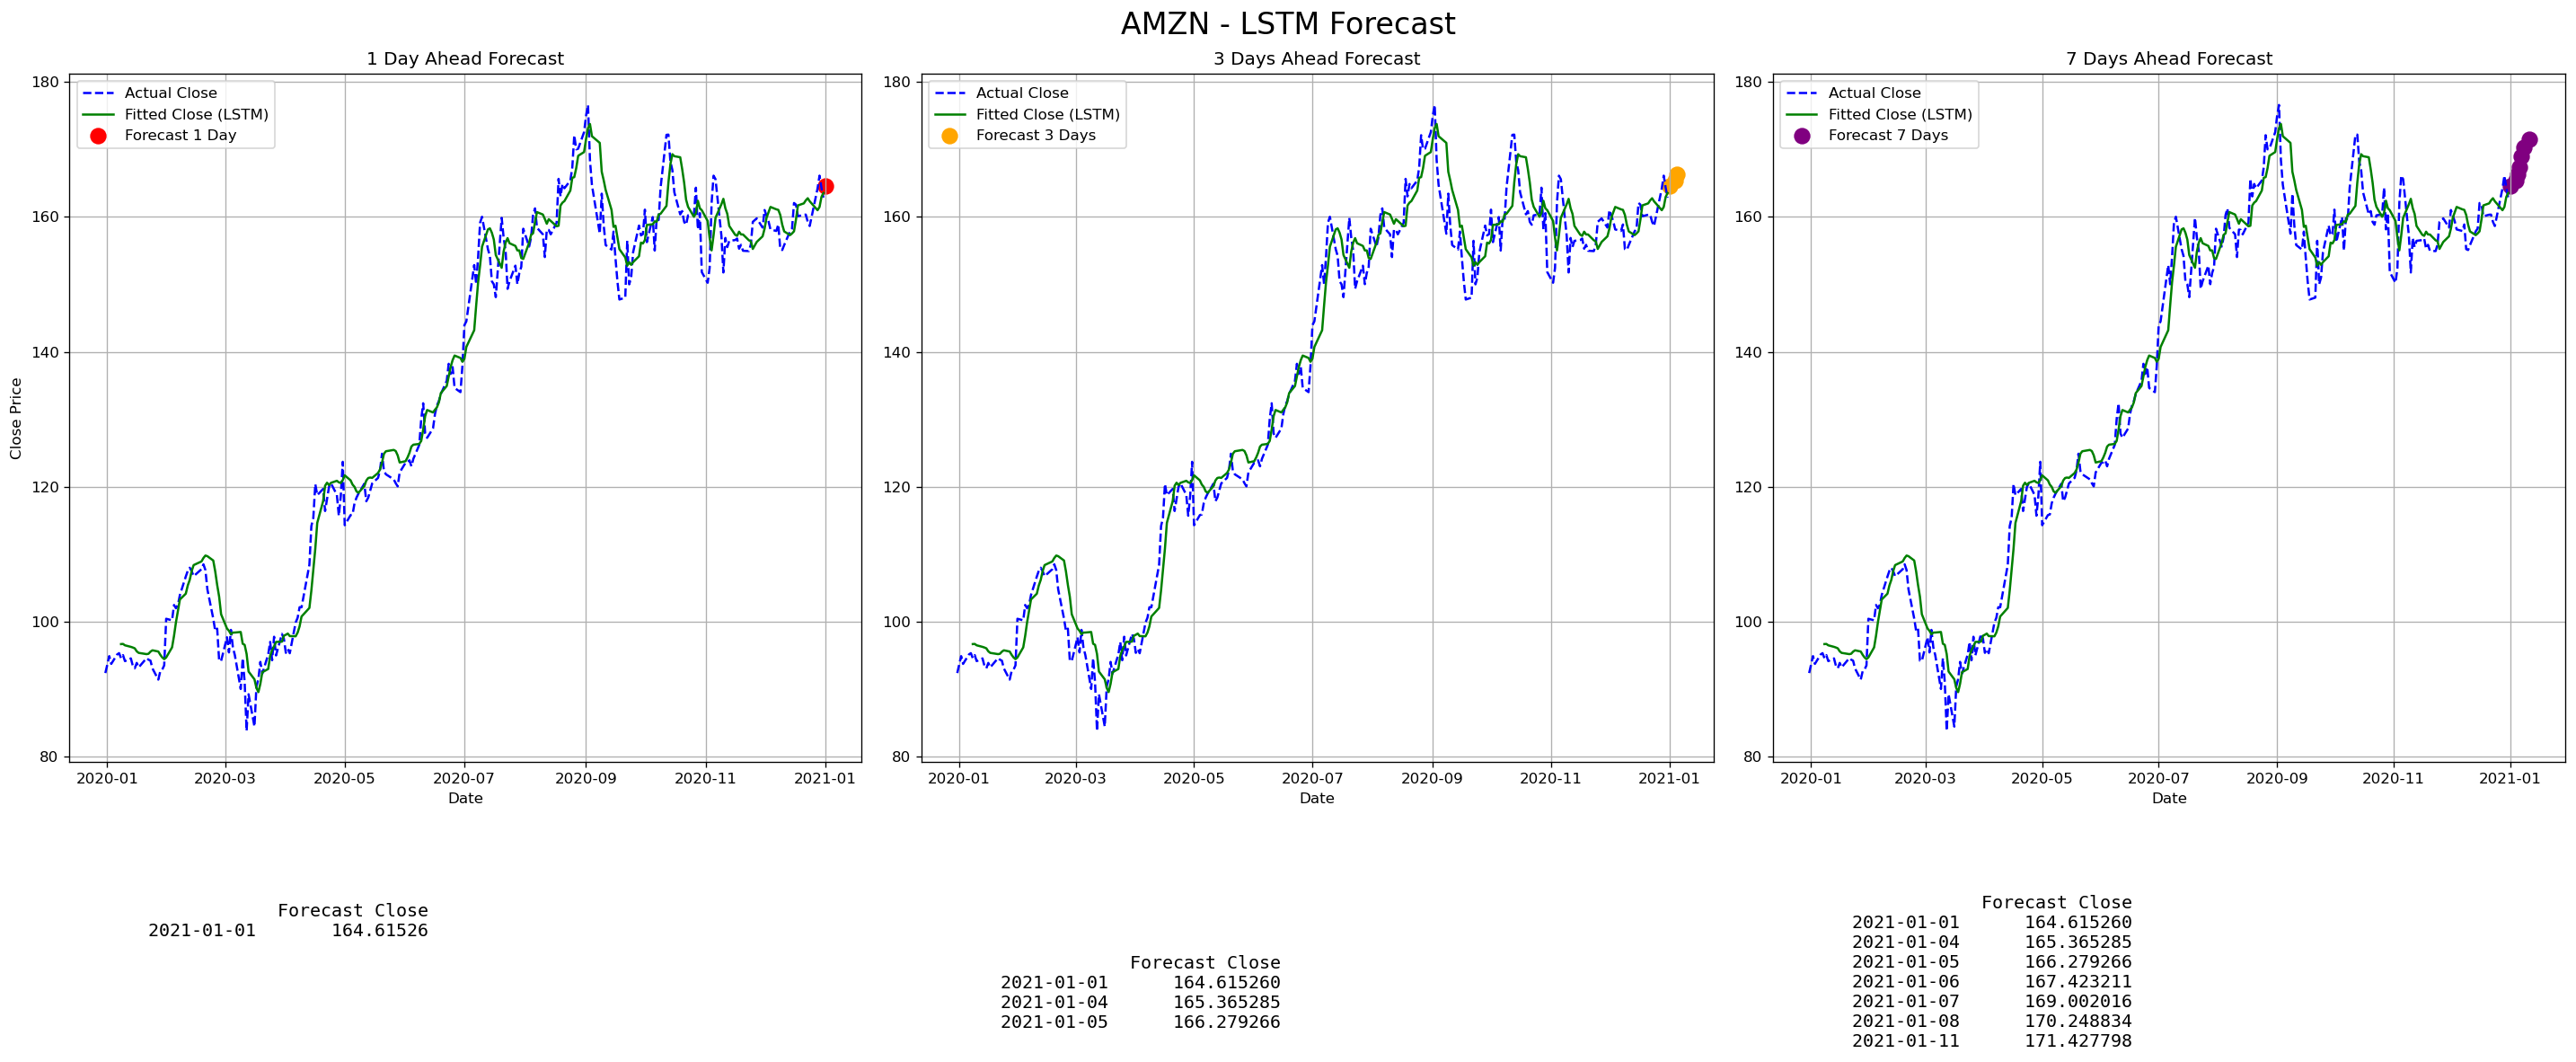


🔵 Processing NVDA...

📊 Model Accuracy Metrics:
Mean Squared Error (MSE): 0.001470
Root Mean Squared Error (RMSE): 0.038335
Mean Absolute Error (MAE): 0.028446
R² Score: 0.983797


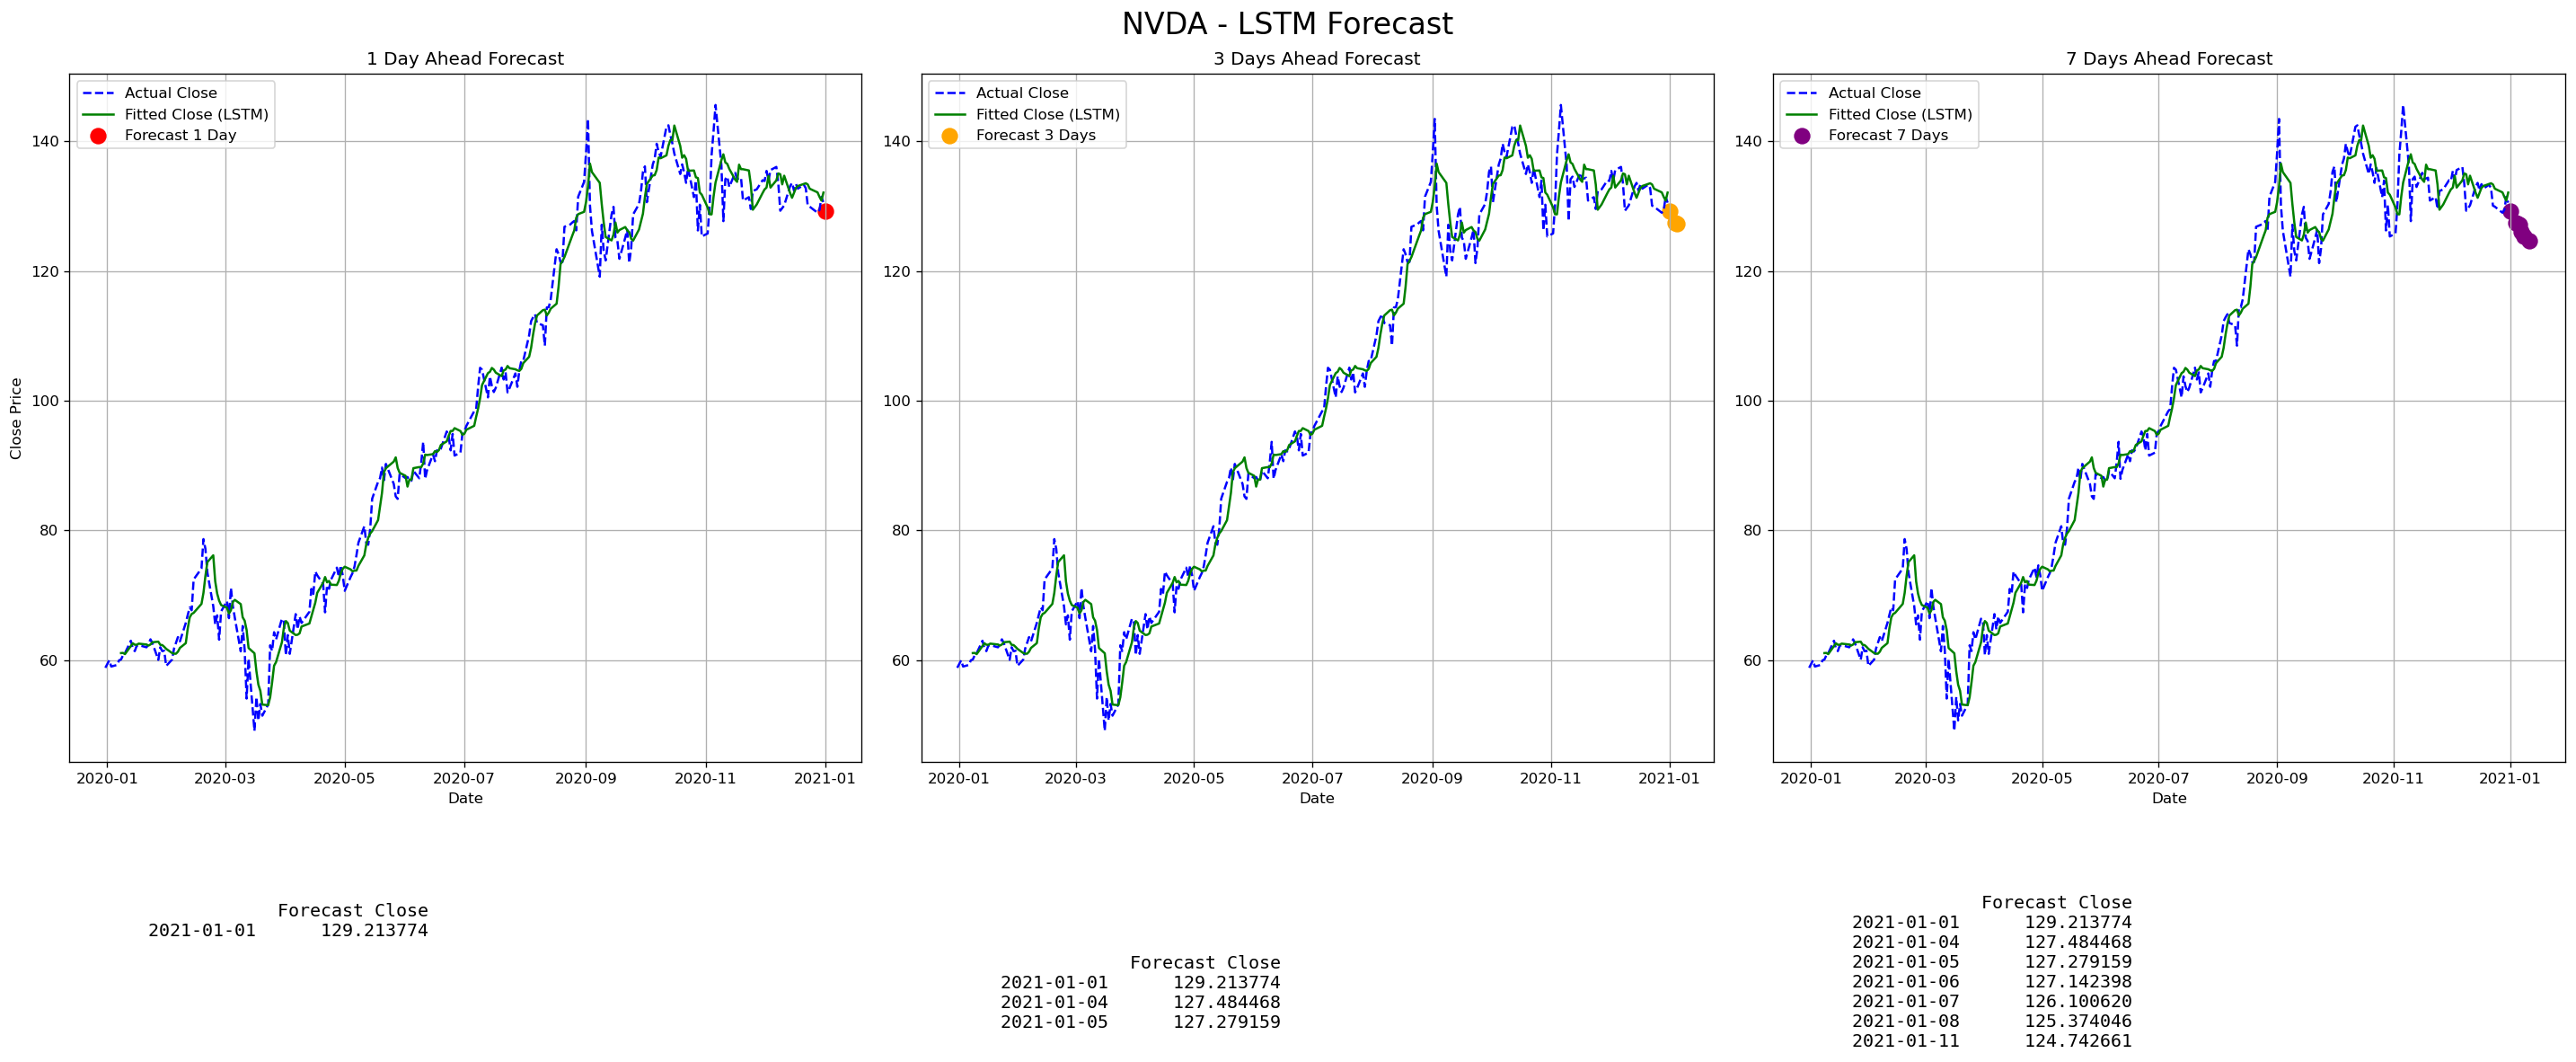


🔵 Processing NFLX...

📊 Model Accuracy Metrics:
Mean Squared Error (MSE): 0.002905
Root Mean Squared Error (RMSE): 0.053901
Mean Absolute Error (MAE): 0.040132
R² Score: 0.953348


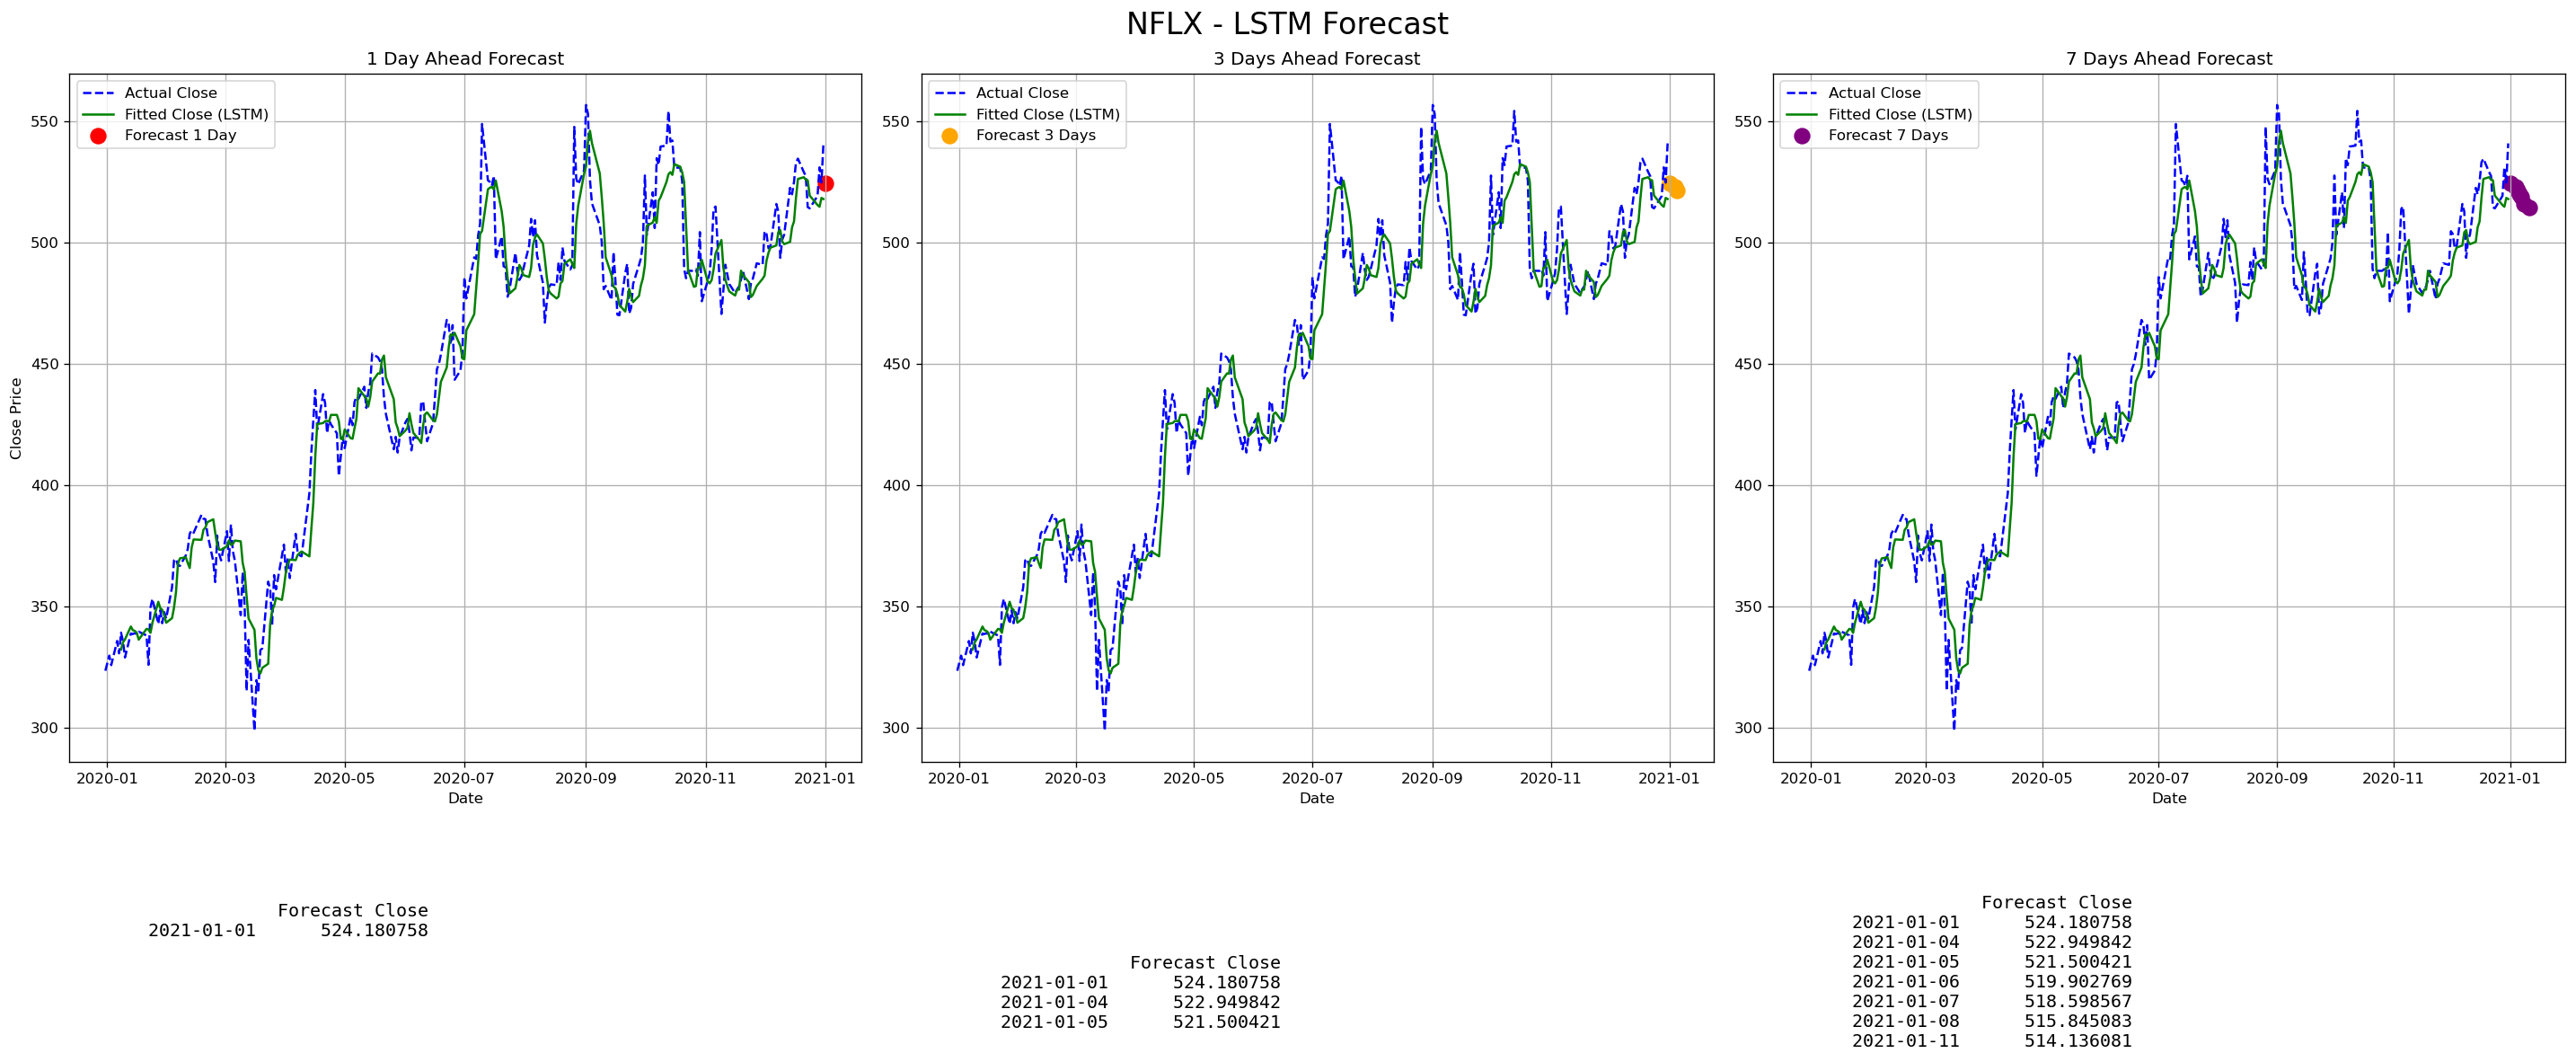

In [218]:
# === Stock list ===
tickers = ['TSLA', 'AAPL', 'AMZN', 'NVDA', 'NFLX']

# === Loop over each stock ===
for ticker in tickers:
    print("=" * 90)
    print(f"\n🔵 Processing {ticker}...")

    # Prepare company data
    df_stock = df_merged_average[df_merged_average['Ticker'] == ticker].copy()
    df_stock['Date'] = pd.to_datetime(df_stock['Date'])
    df_stock.set_index('Date', inplace=True)
    df_stock = df_stock.sort_index()

    # Features and Target
    features = df_stock[['Close', 'Sentiment']]
    target = df_stock['Close']

    # Scale features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Create X and y for LSTM
    X, y = [], []
    n_steps = 5  # lookback window

    for i in range(n_steps, len(features_scaled)):
        X.append(features_scaled[i - n_steps:i])
        y.append(features_scaled[i, 0])  # Close price

    X, y = np.array(X), np.array(y)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, 2)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X, y, epochs=50, batch_size=16, verbose=0)

    # In-sample prediction (training data)
    train_pred_scaled = model.predict(X, verbose=0)

    # Inverse scaling of predictions (combine with sentiment to inverse)
    train_pred_close = scaler.inverse_transform(
        np.hstack([train_pred_scaled, features_scaled[n_steps:, 1].reshape(-1, 1)])
    )[:, 0]

    # === Evaluation Metrics ===
    mse = mean_squared_error(y, train_pred_scaled)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, train_pred_scaled)
    r2 = r2_score(y, train_pred_scaled)

    print("\n📊 Model Accuracy Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score: {r2:.6f}")

    # === Forecast future ===
    last_input = features_scaled[-n_steps:]
    future_dates = pd.date_range(start=df_stock.index[-1] + pd.Timedelta(days=1), periods=7, freq='B')

    def forecast_n_days(n_days):
        current_input = last_input.copy()
        predictions_scaled = []

        for _ in range(n_days):
            pred = model.predict(current_input.reshape(1, n_steps, 2), verbose=0)
            predictions_scaled.append(pred[0][0])

            new_row = np.array([pred[0][0], current_input[-1, 1]])
            current_input = np.vstack([current_input[1:], new_row])

        predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
        predicted_close = scaler.inverse_transform(
            np.hstack([predictions_scaled, np.repeat(current_input[-1, 1], n_days).reshape(-1, 1)])
        )[:, 0]

        return predicted_close

    predicted_close_1 = forecast_n_days(1)
    predicted_close_3 = forecast_n_days(3)
    predicted_close_7 = forecast_n_days(7)

    # === Plotting ===
    fitted_index = df_stock.index[n_steps:]

    fig, axs = plt.subplots(2, 3, figsize=(24, 10), gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(f'{ticker} - LSTM Forecast', fontsize=20)

    # --- 1-Day Forecast ---
    axs[0, 0].plot(df_stock.index, df_stock['Close'], label='Actual Close', linestyle='--', color='blue')
    axs[0, 0].plot(fitted_index, train_pred_close, label='Fitted Close (LSTM)', color='green')
    axs[0, 0].scatter(future_dates[0:1], predicted_close_1, color='red', label='Forecast 1 Day', marker='o', s=100)
    axs[0, 0].set_title('1 Day Ahead Forecast')
    axs[0, 0].set_xlabel('Date')
    axs[0, 0].set_ylabel('Close Price')
    axs[0, 0].legend()
    axs[0, 0].grid()

    axs[1, 0].axis('off')
    forecast_1day = pd.DataFrame({'Forecast Close': predicted_close_1}, index=future_dates[:1])
    axs[1, 0].text(0.1, 0.5, forecast_1day.to_string(), fontsize=12, family='monospace')

    # --- 3-Day Forecast ---
    axs[0, 1].plot(df_stock.index, df_stock['Close'], label='Actual Close', linestyle='--', color='blue')
    axs[0, 1].plot(fitted_index, train_pred_close, label='Fitted Close (LSTM)', color='green')
    axs[0, 1].scatter(future_dates[:3], predicted_close_3, color='orange', label='Forecast 3 Days', marker='o', s=100)
    axs[0, 1].set_title('3 Days Ahead Forecast')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].legend()
    axs[0, 1].grid()

    axs[1, 1].axis('off')
    forecast_3day = pd.DataFrame({'Forecast Close': predicted_close_3}, index=future_dates[:3])
    axs[1, 1].text(0.1, 0.1, forecast_3day.to_string(), fontsize=12, family='monospace')

    # --- 7-Day Forecast ---
    axs[0, 2].plot(df_stock.index, df_stock['Close'], label='Actual Close', linestyle='--', color='blue')
    axs[0, 2].plot(fitted_index, train_pred_close, label='Fitted Close (LSTM)', color='green')
    axs[0, 2].scatter(future_dates, predicted_close_7, color='purple', label='Forecast 7 Days', marker='o', s=100)
    axs[0, 2].set_title('7 Days Ahead Forecast')
    axs[0, 2].set_xlabel('Date')
    axs[0, 2].legend()
    axs[0, 2].grid()

    axs[1, 2].axis('off')
    forecast_7day = pd.DataFrame({'Forecast Close': predicted_close_7}, index=future_dates)
    axs[1, 2].text(0.1, 0.02, forecast_7day.to_string(), fontsize=12, family='monospace')

    # Layout adjustment
    plt.tight_layout()
    plt.show()

    print("=" * 90)


### HyperParameter Tuning for LSTM Model

- In order to achieve better results, I applied a hyperparameter tuning method called `RandomizedSearchCV`. This method randomly samples a subset of parameter combinations from a defined search space, rather than testing all possible combinations. As a result, the R² scores for all models improved.

| Ticker |    Units    | Batch Size | Epochs   | Lr       | RMSE   | MSE     | R² Score |
| ------ | ------------| ---------  | -------- |--------- |--------|---------|----------|
| TSLA   |   50        | 16         | 150      |0.0010    |0.0274  |0.0007   |0.9892    |
| AAPL   |   50        | 32         | 150      |0.001     |0.0339  |0.0011   |0.9842    |
| AMZN   |   32        | 32         | 150      |0.001     |0.0392  |0.0015   |0.9818    |
| NVDA   |   64        | 32         | 150      |0.005     |0.0391  |0.0015   |0.9831    |
| NFLX   |   50        | 64         | 150      |0.005     |0.0552  |0.0030   |0.9509    |

In [222]:
# Company list
tickers = ['TSLA', 'AAPL', 'AMZN', 'NVDA', 'NFLX']

# Hyperparameter space
units_list = [32, 50, 64, 100]
batch_size_list = [16, 32, 64]
epochs_list = [50, 100, 150]
learning_rate_list = [0.001, 0.0005, 0.0001]

# Loop over companies
for ticker in tickers:
    print("\n" + "=" * 90)
    print(f"🔵 Running Random Search for {ticker}...")

    df_stock = df_merged_average[df_merged_average['Ticker'] == ticker].copy()
    df_stock.set_index('Date', inplace=True)
    df_stock = df_stock.sort_index()

    features = df_stock[['Close', 'Sentiment']]
    target = df_stock['Close']

    # Scale features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Create sequences
    X, y = [], []
    n_steps = 5
    for i in range(n_steps, len(features_scaled)):
        X.append(features_scaled[i - n_steps:i])
        y.append(features_scaled[i, 0])
    X, y = np.array(X), np.array(y)

    # Random search trials
    n_trials = 5
    results = []

    for trial in range(n_trials):
        units = random.choice(units_list)
        batch_size = random.choice(batch_size_list)
        epochs = random.choice(epochs_list)
        learning_rate = random.choice(learning_rate_list)

        print(f"\n🔹 Trial {trial+1}/{n_trials} | units={units}, batch_size={batch_size}, epochs={epochs}, lr={learning_rate}")

        # Build and train model
        model = Sequential()
        model.add(LSTM(units, activation='relu', input_shape=(n_steps, 2)))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        train_pred = model.predict(X, verbose=0)
        mse = mean_squared_error(y, train_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, train_pred)

        print(f"   ➤ MSE={mse:.6f}, RMSE={rmse:.6f}, R²={r2:.6f}")

        results.append({
            'units': units,
            'batch_size': batch_size,
            'epochs': epochs,
            'learning_rate': learning_rate,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })

    # Display best results
    results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
    print(f"\n📋 Top Configurations for {ticker}:\n")
    print(results_df)

    best = results_df.iloc[0]
    print(f"\n✅ Best Config for {ticker} → units={best['units']}, batch={best['batch_size']}, "
          f"epochs={best['epochs']}, lr={best['learning_rate']}, RMSE={best['RMSE']:.6f}")



🔵 Running Random Search for TSLA...

🔹 Trial 1/5 | units=50, batch_size=32, epochs=50, lr=0.0005
   ➤ MSE=0.001272, RMSE=0.035671, R²=0.981927

🔹 Trial 2/5 | units=32, batch_size=32, epochs=100, lr=0.0001
   ➤ MSE=0.005917, RMSE=0.076923, R²=0.915955

🔹 Trial 3/5 | units=100, batch_size=32, epochs=150, lr=0.0001
   ➤ MSE=0.001506, RMSE=0.038802, R²=0.978615

🔹 Trial 4/5 | units=32, batch_size=16, epochs=50, lr=0.0005
   ➤ MSE=0.001282, RMSE=0.035809, R²=0.981787

🔹 Trial 5/5 | units=64, batch_size=16, epochs=50, lr=0.0005
   ➤ MSE=0.001184, RMSE=0.034410, R²=0.983182

📋 Top Configurations for TSLA:

   units  batch_size  epochs  learning_rate       MSE      RMSE        R2
0     64          16      50         0.0005  0.001184  0.034410  0.983182
1     50          32      50         0.0005  0.001272  0.035671  0.981927
2     32          16      50         0.0005  0.001282  0.035809  0.981787
3    100          32     150         0.0001  0.001506  0.038802  0.978615
4     32          32  

## Web-Based Dashboard

In [28]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import webbrowser
import threading

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# === Setup Dash app ===
app = dash.Dash(__name__)
server = app.server
tickers = df_merged_average['Ticker'].unique()

# === Layout ===
app.layout = html.Div([
    html.H1("📈 Stock Forecast Dashboard with Sentiment", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Select Company:"),
        dcc.Dropdown(tickers, value='TSLA', id='ticker-select')
    ], style={'width': '30%', 'display': 'inline-block'}),

    html.Div([
        html.Label("Select Model:"),
        dcc.RadioItems(['SARIMAX', 'LSTM'], value='SARIMAX', id='model-select',
                       labelStyle={'display': 'inline-block', 'marginRight': '20px'})
    ], style={'marginLeft': '50px', 'display': 'inline-block'}),

    dcc.Graph(id='forecast-graph'),
    html.Div(id='metrics-output')
])

# === Callback ===
@app.callback(
    [Output('forecast-graph', 'figure'),
     Output('metrics-output', 'children')],
    [Input('ticker-select', 'value'),
     Input('model-select', 'value')]
)
def update_graph(ticker, model_type):
    df_t = df_merged_average[df_merged_average['Ticker'] == ticker].copy()
    df_t.set_index('Date', inplace=True)
    df_t = df_t.sort_index()

    endog = df_t['Close']
    exog = df_t[['Sentiment']]
    future_sentiment = exog['Sentiment'].iloc[-1]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=endog.index, y=endog, mode='lines', name='Historical Close'))

    mse = rmse = mae = r2 = None

    if model_type == 'SARIMAX':
        model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 5),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        fitted = model_fit.fittedvalues

        y_true = endog[1:]
        y_pred = fitted[1:]
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        fig.add_trace(go.Scatter(x=endog.index, y=fitted, mode='lines', name='Fitted (SARIMAX)', line=dict(dash='dot')))

        for days, color in zip([1, 3, 7], ['red', 'orange', 'purple']):
            forecast = model_fit.get_forecast(steps=days, exog=pd.DataFrame({'Sentiment': [future_sentiment]*days}))
            forecast_index = pd.date_range(start=endog.index[-1] + pd.Timedelta(days=1), periods=days, freq='B')
            fig.add_trace(go.Scatter(x=forecast_index, y=forecast.predicted_mean,
                                     mode='markers', marker=dict(size=10, color=color),
                                     name=f'{days}-Day Forecast'))

    elif model_type == 'LSTM':
        features = df_t[['Close', 'Sentiment']]
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)

        X, y = [], []
        n_steps = 5
        for i in range(n_steps, len(features_scaled)):
            X.append(features_scaled[i - n_steps:i])
            y.append(features_scaled[i, 0])
        X, y = np.array(X), np.array(y)

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(n_steps, 2)))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
        model.fit(X, y, epochs=50, batch_size=16, verbose=0)

        train_pred_scaled = model.predict(X, verbose=0)
        sentiment_tail = features_scaled[n_steps:, 1].reshape(-1, 1)
        train_pred_close = scaler.inverse_transform(
            np.hstack([train_pred_scaled, sentiment_tail])
        )[:, 0]

        fitted_index = df_t.index[n_steps:]
        fig.add_trace(go.Scatter(x=fitted_index, y=train_pred_close, mode='lines',
                                 name='Fitted (LSTM)', line=dict(dash='dot')))

        y_true_rescaled = scaler.inverse_transform(np.hstack([y.reshape(-1, 1), sentiment_tail]))[:, 0]
        mse = mean_squared_error(y_true_rescaled, train_pred_close)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_rescaled, train_pred_close)
        r2 = r2_score(y_true_rescaled, train_pred_close)

        last_seq = features_scaled[-n_steps:]
        for step, color in zip([1, 3, 7], ['red', 'orange', 'purple']):
            current_input = last_seq.copy()
            future_sentiment_val = current_input[-1, 1]
            preds = []
            for _ in range(step):
                pred = model.predict(current_input.reshape(1, n_steps, 2), verbose=0)
                preds.append(pred[0][0])
                new_input = np.array([pred[0][0], future_sentiment_val])
                current_input = np.vstack([current_input[1:], new_input])
            preds = np.array(preds).reshape(-1, 1)
            inv_preds = scaler.inverse_transform(np.hstack([preds, np.full_like(preds, future_sentiment_val)]))[:, 0]
            date_fut = df_t.index[-1] + pd.Timedelta(days=step)
            fig.add_trace(go.Scatter(x=[date_fut], y=[inv_preds[-1]],
                                     mode='markers', marker=dict(color=color, size=10),
                                     name=f'{step}-Day Forecast'))

    fig.update_layout(title=f'{ticker} Forecast using {model_type}',
                      xaxis_title='Date', yaxis_title='Close Price',
                      template='plotly_white', legend_title='Legend')

    if all(v is not None for v in [mse, rmse, mae, r2]):
        metric_text = (
            f"📊 **{model_type} Model Metrics**\n\n"
            f"- MSE: `{mse:.4f}`  \n"
            f"- RMSE: `{rmse:.4f}`  \n"
            f"- MAE: `{mae:.4f}`  \n"
            f"- R²: `{r2:.4f}`"
        )
    else:
        metric_text = "⚠️ Model metrics unavailable."

    return fig, dcc.Markdown(metric_text)

# === Auto open browser on run ===
def open_browser():
    webbrowser.open_new("http://127.0.0.1:8050/")

if __name__ == '__main__':
    threading.Timer(1, open_browser).start()
    app.run_server(debug=True)
